# Printing and Plotting Results

Contains two sections:
1. How to create a summary table.
2. How to create plots showing the ranks of the similarity measures.

## Summary Table

This section of the notebook, creates the overview table in our paper. This code can be easily adjusted to also output more detailed tables.

In [28]:
import re
from pathlib import Path

import pandas as pd
import pandas.io.formats.style

import matplotlib.pyplot as plt

from repsim.benchmark.paths import BASE_PATH


measure_to_abbrv = {
    "AlignedCosineSimilarity": "AlignCos",
    "CKA": "CKA",
    "ConcentricityDifference": "ConcDiff",
    "DistanceCorrelation": "DistCorr",
    "EigenspaceOverlapScore": "EOS",
    "GeometryScore": "GS",
    "Gulp": "GULP",
    "HardCorrelationMatch": "HardCorr",
    "IMDScore": "IMD",
    "JaccardSimilarity": "Jaccard",
    "LinearRegression": "LinReg",
    "MagnitudeDifference": "MagDiff",
    "OrthogonalAngularShapeMetricCentered": "AngShape",
    "OrthogonalProcrustesCenteredAndNormalized": "OrthProc",
    "PWCCA": "PWCCA",
    "PermutationProcrustes": "PermProc",
    "ProcrustesSizeAndShapeDistance": "ProcDist",
    "RSA": "RSA",
    "RSMNormDifference": "RSMDiff",
    "RankSimilarity": "RankSim",
    "SVCCA": "SVCCA",
    "SecondOrderCosineSimilarity": "2nd-Cos",
    "SoftCorrelationMatch": "SoftCorr",
    "UniformityDifference": "UnifDiff"
}


Step 1: Load all results.

In [2]:
cleaned_dfs = []
nlp_root = BASE_PATH /"paper_results" / "nlp"
for path in nlp_root.glob("*.csv"):
    df = pd.read_csv(path, index_col=0)
    setting = path.name.split("_")[0]

    pattern = r'(?<=_)sst2(?=_)|(?<=_)mnli(?=_)'
    match = re.search(pattern, path.name)
    assert match is not None
    dataset = match.group(0)

    df["Setting"] = setting
    df["Dataset"] = dataset
    cleaned_dfs.append(df)

data = pd.concat(cleaned_dfs).reset_index(drop=True)
nlp_data = data


In [3]:
cleaned_dfs = []
root = BASE_PATH /"paper_results" /"graph"
for path in root.glob("*.csv"):
    if path.name.endswith("backup.csv"):
        continue

    df = pd.read_csv(path, index_col=0)
    pattern = r"augmentation|label_test|layer_test|output_correlation|shortcut"
    match = re.search(pattern, path.name)
    pattern_to_setting = {
        "augmentation": "aug",
        "label_test": "mem",
        "layer_test": "mono",
        "output_correlation": "correlation",
        "shortcut": "sc",
    }
    setting = pattern_to_setting[match.group(0)]

    pattern = r"(?<=_)cora(?=_)|(?<=_)flickr(?=_)|(?<=_)ogbn-arxiv(?=_)"
    match = re.search(pattern, path.name)
    assert match is not None
    dataset = match.group(0)

    df["Setting"] = setting
    df["Dataset"] = dataset
    cleaned_dfs.append(df)

data = pd.concat(cleaned_dfs).reset_index(drop=True)
graph_data = data

In [4]:
graph_data[(graph_data.representation_dataset=="cora") & (graph_data.Setting == "correlation") & (graph_data.quality_measure == "spearmanr")].groupby(["architecture", "functional_similarity_measure","similarity_measure"]).count()
graph_data[(graph_data.representation_dataset=="cora") & (graph_data.Setting == "correlation") & (graph_data.quality_measure == "spearmanr") & (graph_data.similarity_measure == "AlignedCosineSimilarity") & (graph_data.architecture == "GCN")]

,similarity_measure,quality_measure,model,value,domain,architecture,representation_dataset,identifier,Setting,Dataset,functional_similarity_measure,corr,pval
4761,AlignedCosineSimilarity,spearmanr,NaN,NaN,GRAPHS,GCN,cora,Normal,correlation,cora,JSD,0.016601,0.913809
4764,AlignedCosineSimilarity,spearmanr,NaN,NaN,GRAPHS,GCN,cora,Normal,correlation,cora,Disagreement,-0.084083,0.582905
4767,AlignedCosineSimilarity,spearmanr,NaN,NaN,GRAPHS,GCN,cora,Normal,correlation,cora,AbsoluteAccDiff,-0.331839,0.025952


In [5]:
cleaned_dfs = []
root = BASE_PATH /"paper_results" /"vision"
for path in root.glob("*.csv"):
    df = pd.read_csv(path, index_col=0)
    pattern = r"aug|mem|mono|correlation|sc"
    match = re.search(pattern, path.name)
    pattern_to_setting = {
        "aug": "aug",
        "mem": "mem",
        "mono": "mono",
        "correlation": "correlation",
        "sc": "sc",
    }
    setting = pattern_to_setting[match.group(0)]

    pattern = r"(?<=_)in100(?=_)"
    match = re.search(pattern, path.name)
    assert match is not None
    dataset = match.group(0)

    df["Setting"] = setting
    df["Dataset"] = dataset
    cleaned_dfs.append(df)

data = pd.concat(cleaned_dfs).reset_index(drop=True)
vision_data = data

## Clean and Pivot

Step 2: Combine data into a big dataframe, clean up column names etc., and select data to be shown in table.

In [6]:
# ----------------------------------------------------------------------------------------------------------------------
# Combine data
# ----------------------------------------------------------------------------------------------------------------------
data = pd.concat([nlp_data, graph_data, vision_data])
print(data.columns)

data = data.rename(
    columns={
        "functional_similarity_measure": "Functional Similarity Measure",
        "similarity_measure": "Representational Similarity Measure",
        "quality_measure": "Quality Measure",
    }
)

idx = data.Setting == "correlation"
data.loc[idx, "value"] = data.loc[idx, "corr"]

idx = (data.Setting == "correlation") & (data["Functional Similarity Measure"] == "AbsoluteAccDiff")
data.loc[idx, "Setting"] = "acc_corr"

# ----------------------------------------------------------------------------------------------------------------------
# Exclude data not to be shown in table.
# ----------------------------------------------------------------------------------------------------------------------
idx = (data.Setting == "correlation") & (data["Functional Similarity Measure"] != "JSD")
data = data.loc[~idx]

idx = (data.Setting.isin(["aug", "mem", "sc"])) & (data["Quality Measure"] != "AUPRC")
data = data.loc[~idx]

idx = (data.Setting.isin(["correlation", "acc_corr"])) & (data["Quality Measure"] != "spearmanr")
data = data.loc[~idx]

# idx = (data.Setting.isin(["mono"])) & (data["Quality Measure"] != "violation_rate")
idx = (data.Setting.isin(["mono"])) & (data["Quality Measure"] != "correlation")
data = data.loc[~idx]


# ----------------------------------------------------------------------------------------------------------------------
# Clean up names etc.
# ----------------------------------------------------------------------------------------------------------------------


def beautify_df(data):
    data.loc[:, "Representational Similarity Measure"] = data["Representational Similarity Measure"].map(
        measure_to_abbrv
    )
    data.loc[:, "architecture"] = data["architecture"].map(
        {
            "BERT-L": "BERT",
            "GCN": "GCN",
            "GAT": "GAT",
            "GraphSAGE": "SAGE",
            "VGG11": "VGG11",
            "VGG19": "VGG19",
            "ResNet18": "RNet18",
            "ResNet34": "RNet34",
            "ResNet101": "RNet101",
            "ViT_B32": "ViT_B32",
            "ViT_L32": "ViT_L32",
            "PGNN": "P-GNN",
        }
    )
    data.loc[:, "domain"] = data["domain"].map({"NLP": "Text", "GRAPHS": "Graph", "VISION": "Vision"})
    data.loc[:, "Dataset"] = data["Dataset"].map(
        {
            "mnli_aug_rate0": "MNLI",
            "mnli_mem_rate0": "MNLI",
            "mnli": "MNLI",
            "sst2_sc_rate0558": "SST2",
            "sst2_mem_rate0": "SST2",
            "mnli_sc_rate0354": "MNLI",
            "sst2_aug_rate0": "SST2",
            "sst2": "SST2",
            "flickr": "flickr",
            "ogbn-arxiv": "arXiv",
            "cora": "Cora",
            "in100": "IN100",
        }
    )
    data.loc[:, "Setting"] = data["Setting"].map(
        {
            "aug": "Augmentation",
            "mem": "Random Labels",
            "correlation": "JSD Corr.",
            "acc_corr": "Acc Corr.",
            "mono": "Layer Mono.",
            "sc": "Shortcuts",
        }
    )
    column_order = ["Acc Corr.", "JSD Corr.", "Random Labels", "Shortcuts", "Augmentation", "Layer Mono."]
    data.loc[:, "Setting"] = pd.Categorical(
        data["Setting"],
        categories=column_order,
        ordered=True,
    )
    data.loc[:, "Quality Measure"] = data["Quality Measure"].map(
        {"violation_rate": "Conformity Rate", "AUPRC": "AUPRC", "spearmanr": "Spearman", "correlation": "Spearman"}
    )
    data.loc[data["Quality Measure"] == "Conformity Rate", "value"] = (
        1 - data.loc[data["Quality Measure"] == "Conformity Rate", "value"]
    )  # must be run in conjunction with the above renaming

    data = data.rename(
        columns={
            "domain": "Domain",
            "architecture": "Arch.",
            "Representational Similarity Measure": "Sim Meas.",
            "Quality Measure": "Eval.",
            "Setting": "Test",
        }
    )
    data.loc[data.Test.isin(["Acc Corr.", "JSD Corr."]), "Type"] = "Grounding by Prediction"
    data.loc[data.Test.isin(["Random Labels", "Shortcuts", "Augmentation", "Layer Mono."]), "Type"] = (
        "Grounding by Design"
    )
    return data, column_order


data, column_order = beautify_df(data)

# ----------------------------------------------------------------------------------------------------------------------
# Create aggregated overview table
# ----------------------------------------------------------------------------------------------------------------------
idx = data["Dataset"].isin(["MNLI", "flickr", "IN100"]) & data["Arch."].isin(["SAGE", "BERT", "RNet18"])

pivot = pd.pivot_table(
    data.loc[idx],
    index="Sim Meas.",
    columns=["Type", "Test", "Eval.", "Domain", "Dataset", "Arch."],
    values="value",
)
pivot = pivot.sort_values(by="Sim Meas.")
pivot = pivot.reindex(column_order, axis="columns", level="Test")
pivot = pivot.reindex(["Grounding by Prediction", "Grounding by Design"], axis="columns", level="Type")
pivot

Index(['similarity_measure', 'quality_measure', 'value', 'domain',
       'architecture', 'representation_dataset', 'identifier', 'Setting',
       'Dataset', 'functional_similarity_measure', 'corr', 'pval', 'model'],
      dtype='object')


Type      Grounding by Prediction                                          \
Test                    Acc Corr.                     JSD Corr.             
Eval.                    Spearman                      Spearman             
Domain                      Graph      Text    Vision     Graph      Text   
Dataset                    flickr      MNLI     IN100    flickr      MNLI   
Arch.                        SAGE      BERT    RNet18      SAGE      BERT   
Sim Meas.                                                                   
2nd-Cos                 -0.088933 -0.255661 -0.078977  0.153887  0.162846   
AlignCos                 0.388142  0.245970 -0.077461  0.443083  0.365349   
AngShape                 0.426746  0.275505  0.207265  0.625955  0.264032   
CKA                      0.372069  0.178528  0.356517  0.576416  0.296706   
ConcDiff                -0.059552 -0.001253 -0.106006 -0.033992  0.021212   
DistCorr                 0.359684  0.153476  0.309447  0.430698  0.392358   
EOS                      0.224374  0.027293  0.048059  0.384585  0.363109   
GULP                     0.215020 -0.009559  0.022282  0.383136  0.345191   
HardCorr                 0.322793  0.043116  0.210166  0.504743 -0.265744   
IMD                      0.369775 -0.262979  0.156438  0.306983 -0.385771   
Jaccard                  0.073518 -0.210964 -0.113982  0.421476  0.125560   
LinReg                   0.276629  0.178544  0.184734  0.477316  0.281074   
MagDiff                 -0.005929  0.217886 -0.161382  0.056126  0.011858   
OrthProc                 0.426746  0.275505  0.208847  0.625955  0.264032   
PWCCA                         NaN  0.013866 -0.022328       NaN  0.220167   
PermProc                -0.040711  0.087418  0.070011 -0.098814 -0.062055   
ProcDist                 0.012780  0.280582  0.079966 -0.179842  0.074177   
RSA                      0.300132  0.003956  0.056233  0.630435  0.268248   
RSMDiff                 -0.160611  0.300623  0.086822 -0.042029 -0.176285   
RankSim                  0.143742 -0.087022  0.071132  0.296970  0.083267   
SVCCA                   -0.119236  0.318225  0.294944  0.231621  0.466930   
SoftCorr                 0.307905  0.114250  0.268838  0.525165 -0.228458   
UnifDiff                 0.007115  0.141609 -0.184076  0.016337 -0.016733   

Type                Grounding by Design                                \
Test                      Random Labels                     Shortcuts   
Eval.                             AUPRC                         AUPRC   
Domain       Vision               Graph      Text    Vision     Graph   
Dataset       IN100              flickr      MNLI     IN100    flickr   
Arch.        RNet18                SAGE      BERT    RNet18      SAGE   
Sim Meas.                                                               
2nd-Cos   -0.127009            0.423219  0.386772  0.712253  1.000000   
AlignCos   0.075889            0.423206  1.000000  0.724314  1.000000   
AngShape   0.243874            0.433875  0.900161  0.724314  1.000000   
CKA        0.299078            0.657255  0.752692  1.000000  1.000000   
ConcDiff  -0.292885            0.569848  1.000000  0.988889  0.176244   
DistCorr   0.260211            0.427352  0.750119  1.000000  1.000000   
EOS        0.086561            0.424426  0.616949  0.837241  0.432888   
GULP       0.070619            0.424274  0.611046  0.892925  0.432888   
HardCorr   0.282872            0.457124  0.749357  0.724314  1.000000   
IMD       -0.102108            0.335412  0.727688  1.000000  0.967215   
Jaccard    0.355995            0.430100  0.685921  1.000000  0.827864   
LinReg     0.213432            0.449161  0.569724       NaN  0.609064   
MagDiff   -0.383004            0.717565  0.331188  1.000000  0.782998   
OrthProc   0.242292            0.433875  0.900161  0.724314  1.000000   
PWCCA      0.130147                 NaN  0.649802       NaN       NaN   
PermProc   0.178788            0.904040  0.436244  0.698892  1.000000   
ProcDist  

### Turn values into strings

In [7]:
unpivot = pivot.unstack().reset_index()  # values will be in col "0"
unpivot.loc[:, 1] = unpivot.loc[:, 0].astype("str")
unpivot.loc[:, 1] = unpivot.loc[:, 0].apply(lambda x: str(round(x, 2)))
pivot = unpivot.pivot(index="Sim Meas.",
    columns=["Type", "Test", "Eval.", "Domain", "Dataset", "Arch."],
    values=1,)
unpivot
pivot

Type      Grounding by Prediction                                        \
Test                    Acc Corr.               JSD Corr.                 
Eval.                    Spearman                Spearman                 
Domain                      Graph   Text Vision     Graph   Text Vision   
Dataset                    flickr   MNLI  IN100    flickr   MNLI  IN100   
Arch.                        SAGE   BERT RNet18      SAGE   BERT RNet18   
Sim Meas.                                                                 
2nd-Cos                     -0.09  -0.26  -0.08      0.15   0.16  -0.13   
AlignCos                     0.39   0.25  -0.08      0.44   0.37   0.08   
AngShape                     0.43   0.28   0.21      0.63   0.26   0.24   
CKA                          0.37   0.18   0.36      0.58    0.3    0.3   
ConcDiff                    -0.06   -0.0  -0.11     -0.03   0.02  -0.29   
DistCorr                     0.36   0.15   0.31      0.43   0.39   0.26   
EOS                          0.22   0.03   0.05      0.38   0.36   0.09   
GULP                         0.22  -0.01   0.02      0.38   0.35   0.07   
HardCorr                     0.32   0.04   0.21       0.5  -0.27   0.28   
IMD                          0.37  -0.26   0.16      0.31  -0.39   -0.1   
Jaccard                      0.07  -0.21  -0.11      0.42   0.13   0.36   
LinReg                       0.28   0.18   0.18      0.48   0.28   0.21   
MagDiff                     -0.01   0.22  -0.16      0.06   0.01  -0.38   
OrthProc                     0.43   0.28   0.21      0.63   0.26   0.24   
PWCCA                         nan   0.01  -0.02       nan   0.22   0.13   
PermProc                    -0.04   0.09   0.07      -0.1  -0.06   0.18   
ProcDist                     0.01   0.28   0.08     -0.18   0.07    0.1   
RSA                           0.3    0.0   0.06      0.63   0.27   0.12   
RSMDiff                     -0.16    0.3   0.09     -0.04  -0.18  -0.41   
RankSim                      0.14  -0.09   0.07       0.3   0.08  -0.15   
SVCCA                       -0.12   0.32   0.29      0.23   0.47   0.21   
SoftCorr                     0.31   0.11   0.27      0.53  -0.23   0.45   
UnifDiff                     0.01   0.14  -0.18      0.02  -0.02  -0.34   

Type      Grounding by Design                                      \
Test            Random Labels              Shortcuts                
Eval.                   AUPRC                  AUPRC                
Domain                  Graph  Text Vision     Graph  Text Vision   
Dataset                flickr  MNLI  IN100    flickr  MNLI  IN100   
Arch.                    SAGE  BERT RNet18      SAGE  BERT RNet18   
Sim Meas.                                                           
2nd-Cos                  0.42  0.39   0.71       1.0  0.59    1.0   
AlignCos                 0.42   1.0   0.72       1.0  0.58    1.0   
AngShape                 0.43   0.9   0.72       1.0   0.6    1.0   
CKA                      0.66  0.75    1.0       1.0  0.59    1.0   
ConcDiff                 0.57   1.0   0.99      0.18  0.38   0.53   
DistCorr                 0.43  0.75    1.0       1.0  0.58    1.0   
EOS                      0.42  0.62   0.84      0.43  0.57    1.0   
GULP                     0.42  0.61   0.89      0.43  0.56    1.0   
HardCorr                 0.46  0.75   0.72       1.0  0.55   0.97   
IMD                      0.34  0.73    1.0      0.97  0.53   0.67   
Jaccard                  0.43  0.69    1.0      0.83  0.56    1.0   
LinReg                   0.45  0.57    nan      0.61  0.46   0.99   
MagDiff                  0.72  0.33    1.0      0.78  0.48   0.37   
OrthProc                 0.43   0.9   0.72       1.0   0.6    1.0   
PWCCA                     nan  0.65    nan       nan  0.56   0.99   
PermProc                  0.9  0.44    0.7       1.0  0.52   0.72   
ProcDist                 0.62  0.98   0.72       1.0  0.54    1.0   
RSA                      0.42  0.46   0.75       1.0  0.58    1.0   
RSMDiff                 

### Significance Indicators

In [8]:
idx = data["Dataset"].isin(["MNLI", "flickr", "IN100"]) & data["Arch."].isin(["SAGE", "BERT", "RNet18"]) & data.Test.isin(["Acc Corr.", "JSD Corr."])
data_corr = data.loc[idx].copy()


def pval_str(pval):
    # if pval == pd.notna
    if isinstance(pval, float):
        if pval <= 0.01:
            return r"$^{**}$"
            # return r"$^{\dagger}$"
        if pval <= 0.05:
            return r"$^{*\phantom{*}}$"
            # return r"$^{\ddagger}$"
    return r"$^{\phantom{**}}$"

def significance_via_text_style(pval):
    if pval <= 0.01:
        return [r"\underline{\underline{", r"}}"]
    if pval <= 0.05:
        return [r"\underline{", r"}"]
    return ["", ""]

data_corr["val_comb"] = data_corr["value"].apply(lambda x: f"{round(x, ndigits=2):.2f}") + data_corr["pval"].apply(pval_str)
# data_corr["val_comb"] = data_corr["pval"].apply(significance_via_text_style).apply(lambda x: x[0]) + data_corr["value"].apply(lambda x: f"{round(x, ndigits=2):.2f}") + data_corr["pval"].apply(significance_via_text_style).apply(lambda x: x[1])
data_corr

pivot_corr = data_corr.pivot(
    index="Sim Meas.",
    columns=["Type", "Test", "Eval.", "Domain", "Dataset", "Arch."],
    values=["val_comb"],
).sort_values(
    by="Sim Meas."
).reindex(
    column_order, axis="columns", level="Test"
).reindex(
    ["Graph", "Text", "Vision"], axis="columns", level="Domain"
).loc[:, "val_comb"]
pivot_corr

Type      Grounding by Prediction                          \
Test                    Acc Corr.                           
Eval.                    Spearman                           
Domain                      Graph                    Text   
Dataset                    flickr                    MNLI   
Arch.                        SAGE                    BERT   
Sim Meas.                                                   
2nd-Cos    -0.09$^{\phantom{**}}$  -0.26$^{\phantom{**}}$   
AlignCos              0.39$^{**}$   0.25$^{\phantom{**}}$   
AngShape              0.43$^{**}$   0.28$^{\phantom{**}}$   
CKA         0.37$^{*\phantom{*}}$   0.18$^{\phantom{**}}$   
ConcDiff   -0.06$^{\phantom{**}}$  -0.00$^{\phantom{**}}$   
DistCorr    0.36$^{*\phantom{*}}$   0.15$^{\phantom{**}}$   
EOS         0.22$^{\phantom{**}}$   0.03$^{\phantom{**}}$   
GULP        0.22$^{\phantom{**}}$  -0.01$^{\phantom{**}}$   
HardCorr    0.32$^{*\phantom{*}}$   0.04$^{\phantom{**}}$   
IMD         0.37$^{*\phantom{*}}$  -0.26$^{\phantom{**}}$   
Jaccard     0.07$^{\phantom{**}}$  -0.21$^{\phantom{**}}$   
LinReg                0.28$^{**}$   0.18$^{\phantom{**}}$   
MagDiff    -0.01$^{\phantom{**}}$   0.22$^{\phantom{**}}$   
OrthProc              0.43$^{**}$   0.28$^{\phantom{**}}$   
PWCCA                         NaN   0.01$^{\phantom{**}}$   
PermProc   -0.04$^{\phantom{**}}$   0.09$^{\phantom{**}}$   
ProcDist    0.01$^{\phantom{**}}$   0.28$^{\phantom{**}}$   
RSA         0.30$^{*\phantom{*}}$   0.00$^{\phantom{**}}$   
RSMDiff    -0.16$^{\phantom{**}}$   0.30$^{*\phantom{*}}$   
RankSim     0.14$^{\phantom{**}}$  -0.09$^{\phantom{**}}$   
SVCCA      -0.12$^{\phantom{**}}$   0.32$^{*\phantom{*}}$   
SoftCorr    0.31$^{*\phantom{*}}$   0.11$^{\phantom{**}}$   
UnifDiff    0.01$^{\phantom{**}}$   0.14$^{\phantom{**}}$   

Type                                                       \
Test                                            JSD Corr.   
Eval.                                            Spearman   
Domain                     Vision                   Graph   
Dataset                     IN100                  flickr   
Arch.                      RNet18                    SAGE   
Sim Meas.                                                   
2nd-Cos    -0.08$^{\phantom{**}}$   0.15$^{\phantom{**}}$   
AlignCos   -0.08$^{\phantom{**}}$             0.44$^{**}$   
AngShape    0.21$^{\phantom{**}}$             0.63$^{**}$   
CKA         0.36$^{*\phantom{*}}$             0.58$^{**}$   
ConcDiff   -0.11$^{\phantom{**}}$  -0.03$^{\phantom{**}}$   
DistCorr    0.31$^{*\phantom{*}}$             0.43$^{**}$   
EOS         0.05$^{\phantom{**}}$             0.38$^{**}$   
GULP        0.02$^{\phantom{**}}$             0.38$^{**}$   
HardCorr    0.21$^{\phantom{**}}$             0.50$^{**}$   
IMD         0.16$^{\phantom{**}}$   0.31$^{*\phantom{*}}$   
Jaccard    -0.11$^{\phantom{**}}$             0.42$^{**}$   
LinReg      0.18$^{\phantom{**}}$             0.48$^{**}$   
MagDiff    -0.16$^{\phantom{**}}$   0.06$^{\phantom{**}}$   
OrthProc    0.21$^{\phantom{**}}$             0.63$^{**}$   
PWCCA      -0.02$^{\phantom{**}}$                     NaN   
PermProc    0.07$^{\phantom{**}}$  -0.10$^{\phantom{**}}$   
ProcDist    0.08$^{\phantom{**}}$  -0.18$^{\phantom{**}}$   
RSA         0.06$^{\phantom{**}}$             0.63$^{**}$   
RSMDiff     0.09$^{\phantom{**}}$  -0.04$^{\phantom{**}}$   
RankSim     0.07$^{\phantom{**}}$   0.30$^{*\phantom{*}}$   
SVCCA       0.29$^{*\phantom{*}}$   0.23$^{\phantom{**}}$   
SoftCorr    0.27$^{\phantom{**}}$             0.53$^{**}$   
UnifDiff   -0.18$^{\phantom{**}}$   0.02$^{\phantom{**}}$   

Type                                                       
Test                                                       
Eval.                                                      
Domain                       Text                  Vision  
Dataset                      MNLI                   IN100  
Arch.                        BERT     

In [9]:
# pivot.loc[:, ("Grounding by Prediction")].astype("str", copy=False)
# pivot.loc[:, ("Grounding by Prediction", "Acc Corr.", "Spearman", "Graph", "flickr", "SAGE")] = pivot.loc[:, ("Grounding by Prediction", "Acc Corr.", "Spearman", "Graph", "flickr", "SAGE")].astype("str")
# pivot.loc[:, ("Grounding by Prediction")].dtypes

pivot.loc[:, ("Grounding by Prediction")] = pivot_corr
pivot

Type      Grounding by Prediction                          \
Test                    Acc Corr.                           
Eval.                    Spearman                           
Domain                      Graph                    Text   
Dataset                    flickr                    MNLI   
Arch.                        SAGE                    BERT   
Sim Meas.                                                   
2nd-Cos    -0.09$^{\phantom{**}}$  -0.26$^{\phantom{**}}$   
AlignCos              0.39$^{**}$   0.25$^{\phantom{**}}$   
AngShape              0.43$^{**}$   0.28$^{\phantom{**}}$   
CKA         0.37$^{*\phantom{*}}$   0.18$^{\phantom{**}}$   
ConcDiff   -0.06$^{\phantom{**}}$  -0.00$^{\phantom{**}}$   
DistCorr    0.36$^{*\phantom{*}}$   0.15$^{\phantom{**}}$   
EOS         0.22$^{\phantom{**}}$   0.03$^{\phantom{**}}$   
GULP        0.22$^{\phantom{**}}$  -0.01$^{\phantom{**}}$   
HardCorr    0.32$^{*\phantom{*}}$   0.04$^{\phantom{**}}$   
IMD         0.37$^{*\phantom{*}}$  -0.26$^{\phantom{**}}$   
Jaccard     0.07$^{\phantom{**}}$  -0.21$^{\phantom{**}}$   
LinReg                0.28$^{**}$   0.18$^{\phantom{**}}$   
MagDiff    -0.01$^{\phantom{**}}$   0.22$^{\phantom{**}}$   
OrthProc              0.43$^{**}$   0.28$^{\phantom{**}}$   
PWCCA                         NaN   0.01$^{\phantom{**}}$   
PermProc   -0.04$^{\phantom{**}}$   0.09$^{\phantom{**}}$   
ProcDist    0.01$^{\phantom{**}}$   0.28$^{\phantom{**}}$   
RSA         0.30$^{*\phantom{*}}$   0.00$^{\phantom{**}}$   
RSMDiff    -0.16$^{\phantom{**}}$   0.30$^{*\phantom{*}}$   
RankSim     0.14$^{\phantom{**}}$  -0.09$^{\phantom{**}}$   
SVCCA      -0.12$^{\phantom{**}}$   0.32$^{*\phantom{*}}$   
SoftCorr    0.31$^{*\phantom{*}}$   0.11$^{\phantom{**}}$   
UnifDiff    0.01$^{\phantom{**}}$   0.14$^{\phantom{**}}$   

Type                                                       \
Test                                            JSD Corr.   
Eval.                                            Spearman   
Domain                     Vision                   Graph   
Dataset                     IN100                  flickr   
Arch.                      RNet18                    SAGE   
Sim Meas.                                                   
2nd-Cos    -0.08$^{\phantom{**}}$   0.15$^{\phantom{**}}$   
AlignCos   -0.08$^{\phantom{**}}$             0.44$^{**}$   
AngShape    0.21$^{\phantom{**}}$             0.63$^{**}$   
CKA         0.36$^{*\phantom{*}}$             0.58$^{**}$   
ConcDiff   -0.11$^{\phantom{**}}$  -0.03$^{\phantom{**}}$   
DistCorr    0.31$^{*\phantom{*}}$             0.43$^{**}$   
EOS         0.05$^{\phantom{**}}$             0.38$^{**}$   
GULP        0.02$^{\phantom{**}}$             0.38$^{**}$   
HardCorr    0.21$^{\phantom{**}}$             0.50$^{**}$   
IMD         0.16$^{\phantom{**}}$   0.31$^{*\phantom{*}}$   
Jaccard    -0.11$^{\phantom{**}}$             0.42$^{**}$   
LinReg      0.18$^{\phantom{**}}$             0.48$^{**}$   
MagDiff    -0.16$^{\phantom{**}}$   0.06$^{\phantom{**}}$   
OrthProc    0.21$^{\phantom{**}}$             0.63$^{**}$   
PWCCA      -0.02$^{\phantom{**}}$                     NaN   
PermProc    0.07$^{\phantom{**}}$  -0.10$^{\phantom{**}}$   
ProcDist    0.08$^{\phantom{**}}$  -0.18$^{\phantom{**}}$   
RSA         0.06$^{\phantom{**}}$             0.63$^{**}$   
RSMDiff     0.09$^{\phantom{**}}$  -0.04$^{\phantom{**}}$   
RankSim     0.07$^{\phantom{**}}$   0.30$^{*\phantom{*}}$   
SVCCA       0.29$^{*\phantom{*}}$   0.23$^{\phantom{**}}$   
SoftCorr    0.27$^{\phantom{**}}$             0.53$^{**}$   
UnifDiff   -0.18$^{\phantom{**}}$   0.02$^{\phantom{**}}$   

Type                                                      Grounding by Design  \
Test                                                            Random Labels   
Eval.                                                                   AUPRC   
Domain                       Text                  Vision               Graph   
Dataset       

Step 3: Convert into latex table.

In [10]:
styled = pd.io.formats.style.Styler(
    pivot,
    precision=2,
)

# Highlight top value
# latex_str = styled.highlight_max(axis=0, props="textbf:--rwrap;").to_latex(
#     hrules=True,
#     position="t",
#     label="tab:result_overview",
# )
latex_str = styled.to_latex(hrules=True, position="t", label="tab:result_overview",)


# ----- Manual modifications --------
latex_str = latex_str.split("\n")

# Center headers
pattern = r"\{r\}"
replacement = r"{c}"
latex_str = [re.sub(pattern, replacement, line) if i in [5, 6, 7] else line for i, line in enumerate(latex_str)]

# Remove measure row
latex_str.pop(11)

# Add vertical bars
line_no = 2
# line_no = 3
mod_line = latex_str[line_no][:17] + "".join(["|rrr"] * 6) + "}"
latex_str[line_no] = mod_line

# Make every second row gray
latex_str = [
    r"\rowcolor{Gray}" + line if i >= 12 and (i - 12) % 2 == 0 else line for i, line in enumerate(latex_str[:-4])
] + latex_str[-4:]
latex_str = "\n".join(latex_str)
print(latex_str)

\begin{table}[t]
\label{tab:result_overview}
\begin{tabular}{l|rrr|rrr|rrr|rrr|rrr|rrr}
\toprule
Type & \multicolumn{6}{r}{Grounding by Prediction} & \multicolumn{12}{r}{Grounding by Design} \\
Test & \multicolumn{3}{c}{Acc Corr.} & \multicolumn{3}{c}{JSD Corr.} & \multicolumn{3}{c}{Random Labels} & \multicolumn{3}{c}{Shortcuts} & \multicolumn{3}{c}{Augmentation} & \multicolumn{3}{c}{Layer Mono.} \\
Eval. & \multicolumn{3}{c}{Spearman} & \multicolumn{3}{c}{Spearman} & \multicolumn{3}{c}{AUPRC} & \multicolumn{3}{c}{AUPRC} & \multicolumn{3}{c}{AUPRC} & \multicolumn{3}{c}{Spearman} \\
Domain & Graph & Text & Vision & Graph & Text & Vision & Graph & Text & Vision & Graph & Text & Vision & Graph & Text & Vision & Graph & Text & Vision \\
Dataset & flickr & MNLI & IN100 & flickr & MNLI & IN100 & flickr & MNLI & IN100 & flickr & MNLI & IN100 & flickr & MNLI & IN100 & flickr & MNLI & IN100 \\
Arch. & SAGE & BERT & RNet18 & SAGE & BERT & RNet18 & SAGE & BERT & RNet18 & SAGE & BERT & RNet18 & SA

## Rankplots

Requires section above to be run as well.

In [163]:
import seaborn as sns

sns.set_theme("paper", style="white", font_scale=1.5)


Combine data similarly to before, but do not filter out specific parts.

In [216]:
data = pd.concat([nlp_data, graph_data, vision_data])
data = data.rename(
    columns={
        "functional_similarity_measure": "Functional Similarity Measure",
        "similarity_measure": "Representational Similarity Measure",
        "quality_measure": "Quality Measure",
    }
)
data = data.reset_index()

idx = data.Setting == "correlation"
data.loc[idx, "value"] = data.loc[idx, "corr"]

idx = data["Quality Measure"].isin(["AUPRC", "spearmanr", "correlation"])
data = data.loc[idx]

idx = data.Setting == "correlation"
data.loc[idx, "Setting"] = data.loc[idx, "Setting"] + data.loc[idx, "Functional Similarity Measure"]

idx = ~(data.Setting == "mono")
data.loc[idx, "model"] = "agg"

data["rank"] = data.groupby(["domain", "Setting", "Dataset", "architecture", "model"], as_index=True)["value"].rank(
    ascending=False
)

# combine layer mono results to equally weight experiments
idx = data.model != "agg"
data.loc[idx, "rank"] = data[idx].groupby(["domain", "Setting", "Dataset", "architecture"])["rank"].mean().reset_index()
data = data.drop_duplicates(subset=["domain", "Setting", "Dataset", "architecture", "Representational Similarity Measure", "Functional Similarity Measure", "Quality Measure"])

data.loc[:, "Representational Similarity Measure"] = data["Representational Similarity Measure"].map(measure_to_abbrv)
data.loc[:, "architecture"] = data["architecture"].map(
    {
        "BERT-L": "BERT",
        "GCN": "GCN",
        "GAT": "GAT",
        "GraphSAGE": "SAGE",
        "VGG11": "VGG11",
        "VGG19": "VGG19",
        "ResNet18": "RNet18",
        "ResNet34": "RNet34",
        "ResNet101": "RNet101",
        "ViT_B32": "ViT_B32",
        "ViT_L32": "ViT_L32",
    }
)
data.loc[:, "domain"] = data["domain"].map({"NLP": "Language", "GRAPHS": "Graph", "VISION": "Vision"})
data.loc[:, "Dataset"] = data["Dataset"].map(
    {
        "mnli_aug_rate0": "MNLI",
        "mnli_mem_rate0": "MNLI",
        "mnli": "MNLI",
        "sst2_sc_rate0558": "SST2",
        "sst2_mem_rate0": "SST2",
        "mnli_sc_rate0354": "MNLI",
        "sst2_aug_rate0": "SST2",
        "sst2": "SST2",
        "flickr": "flickr",
        "ogbn-arxiv": "arXiv",
        "cora": "Cora",
        "in100": "IN100",
    }
)
data.loc[:, "Setting"] = data["Setting"].map(
    {
        "aug": "Augmentation",
        "mem": "Random Labels",
        "correlationJSD": "JSD Corr.",
        "correlationAbsoluteAccDiff": "Acc Corr.",
        "correlationDisagreement": "Disagr. Corr.",
        "acc_corr": "Acc Corr.",
        "mono": "Layer Mono.",
        "sc": "Shortcuts",
    }
)

data.loc[:, "Quality Measure"] = data["Quality Measure"].map(
    {"violation_rate": "Conformity Rate", "AUPRC": "AUPRC", "spearmanr": "Spearman", "correlation": "Spearman"}
)
data.loc[data["Quality Measure"] == "Conformity Rate", "value"] = (
    1 - data.loc[data["Quality Measure"] == "Conformity Rate", "value"]
)  # must be run in conjunction with the above renaming

data = data.rename(
    columns={
        "domain": "Modality",
        "architecture": "Arch.",
        "Representational Similarity Measure": "Sim Meas.",
        "Quality Measure": "Eval.",
        "Setting": "Scenario",
    }
)

data = data.sort_values(by=["Sim Meas."])

### Summary

Rank measures.

In [217]:
avg_ranks = data.groupby(["Modality", "Sim Meas."])["rank"].agg(["mean", "median"]).reset_index()
avg_ranks = avg_ranks.rename(columns={"mean": "avg_rank", "median": "med_rank"})
avg_ranks

,Modality,Sim Meas.,avg_rank,med_rank
0,Graph,2nd-Cos,8.289474,6.0
1,Graph,AlignCos,11.078947,10.0
2,Graph,AngShape,9.850877,10.5
3,Graph,CKA,10.096491,9.0
4,Graph,ConcDiff,16.166667,18.0
...,...,...,...,...
64,Vision,RSMDiff,14.187500,14.0
65,Vision,RankSim,10.207317,8.0
66,Vision,SVCCA,13.231707,15.0
67,Vision,SoftCorr,13.402439,15.0


Create plots.

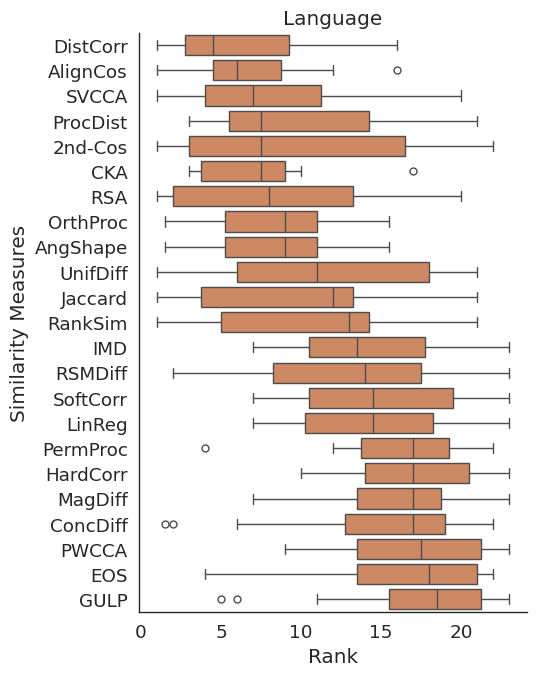

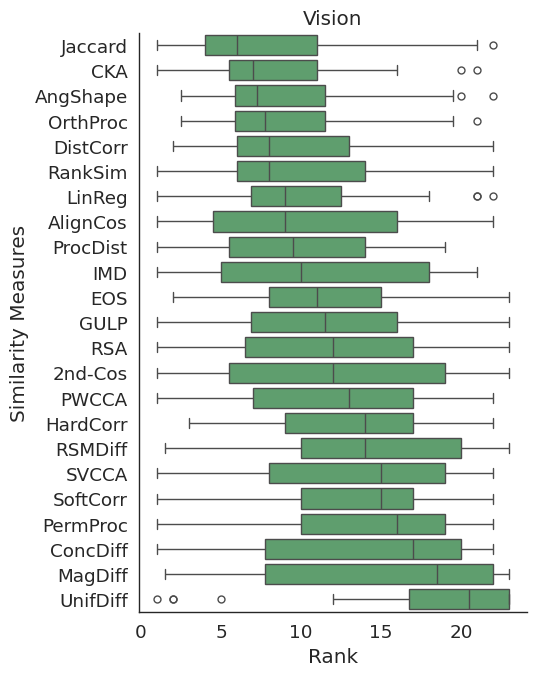

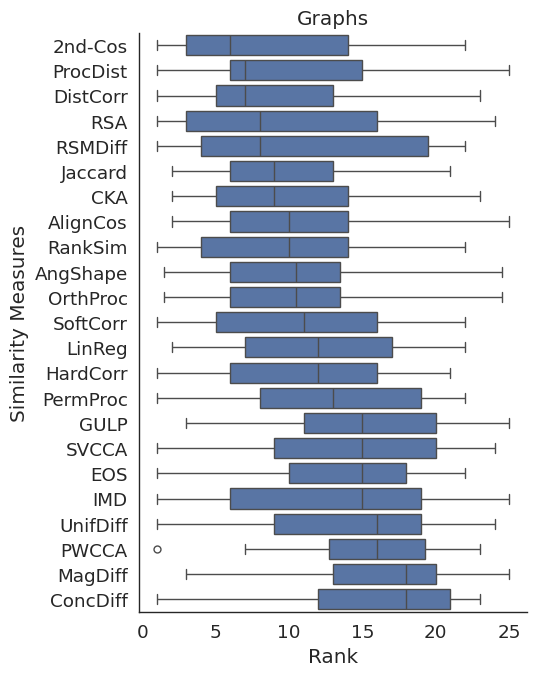

In [218]:
plot_data = pd.merge(data, avg_ranks).sort_values(by=["med_rank"])
# for mod in ["Vision"]:
for mod in plot_data.Modality.unique():
    g = sns.catplot(
        data=plot_data[plot_data.Modality == mod],
        x="rank",
        y="Sim Meas.",
        hue="Modality",
        kind="box",
        height=7,
        aspect=0.8,
        col="Modality",
        palette={"Language": "C1", "Vision": "C2", "Graph": "C0"},
        legend=False
    )
    ax = g.axes[0, 0]
    ax.set_xlabel("Rank")
    ax.set_ylabel("Similarity Measures")

    if mod == "Graph":
        ax.set_title("Graphs")
    else:
        ax.set_title(mod)
    g.savefig(BASE_PATH / "figs" / f"aggregated_ver_{mod}.pdf", bbox_inches="tight")

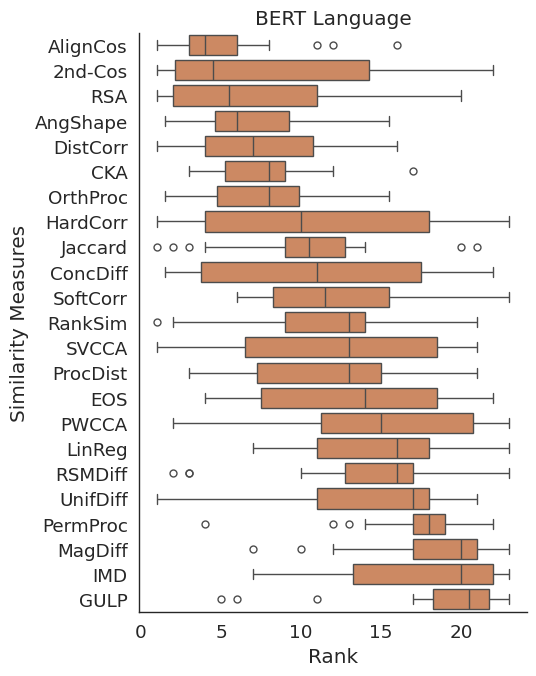

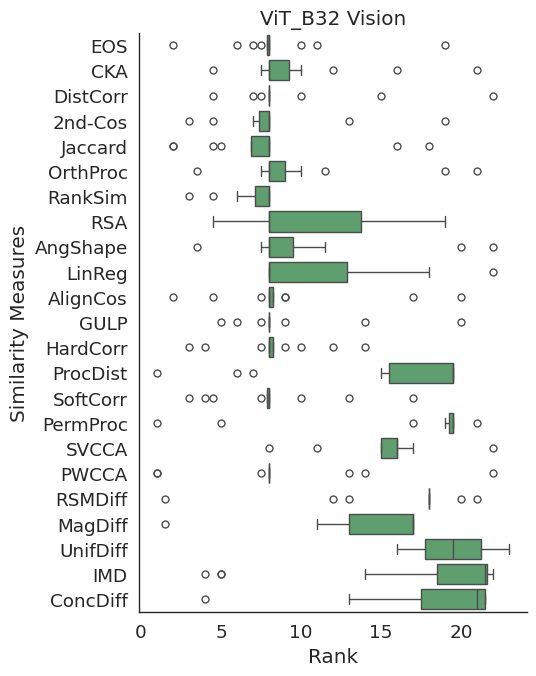

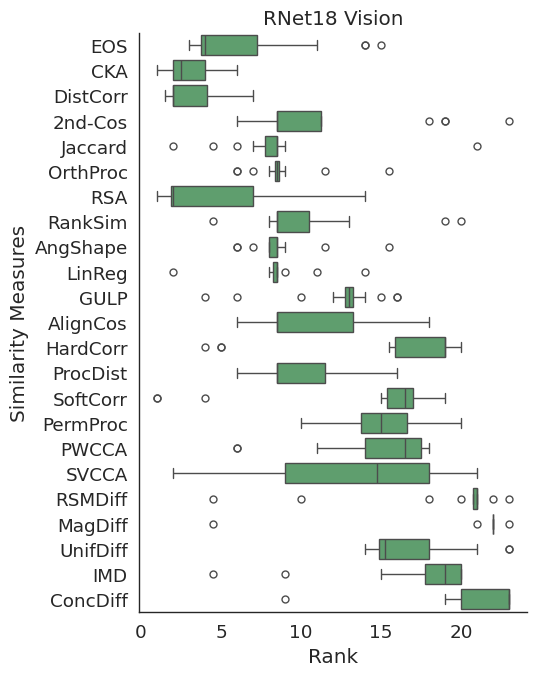

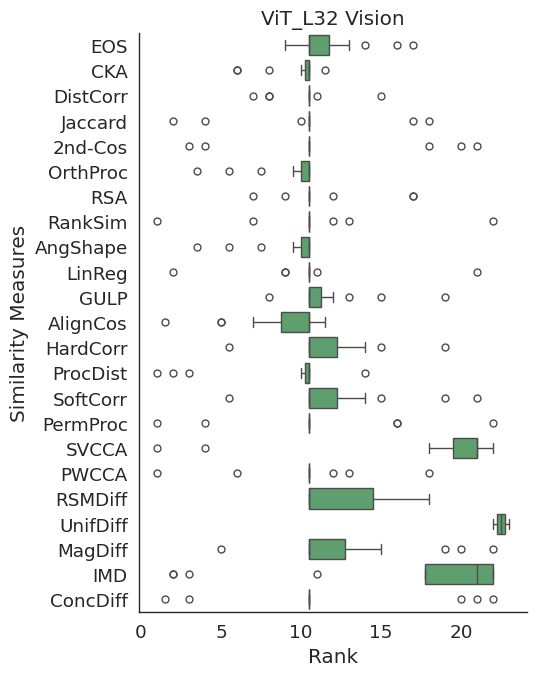

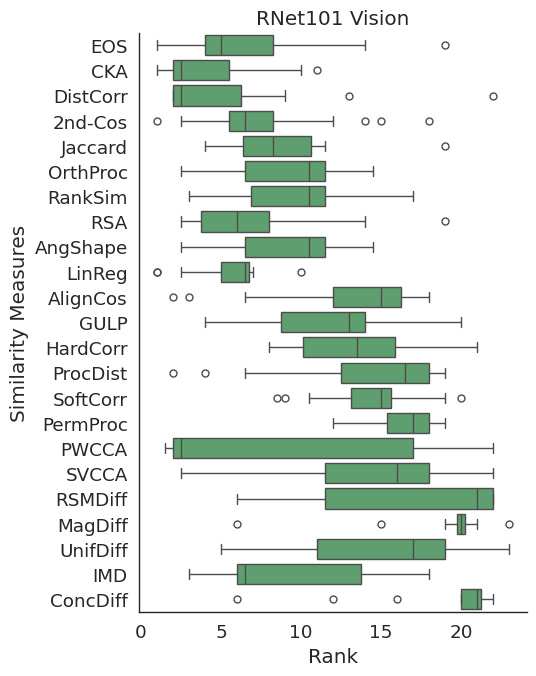

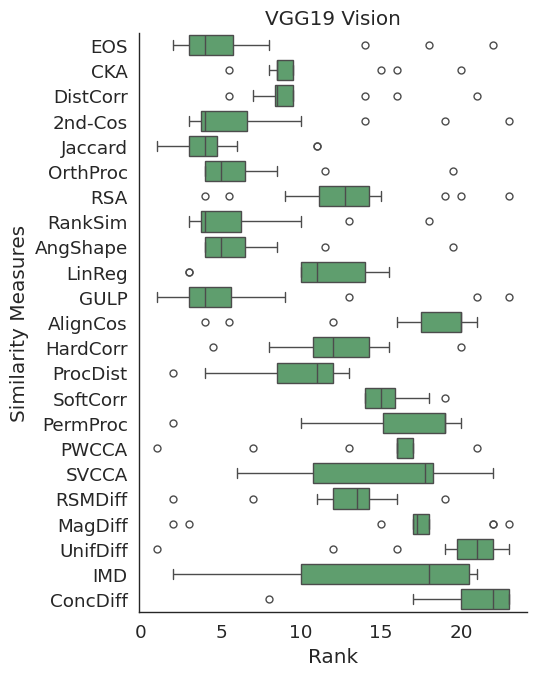

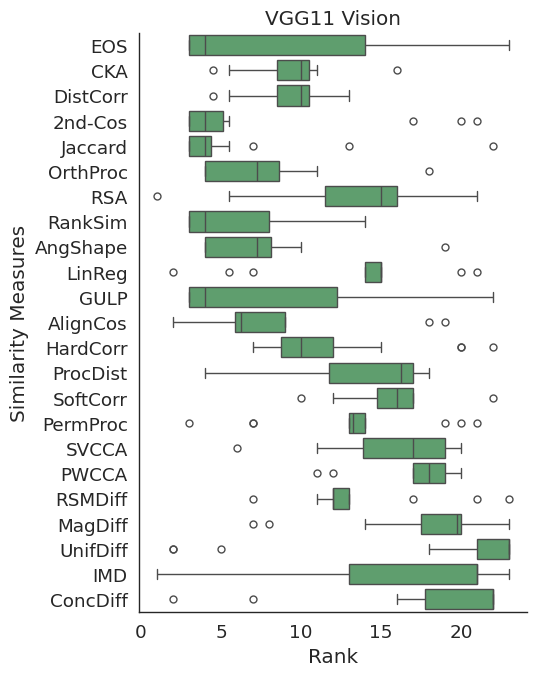

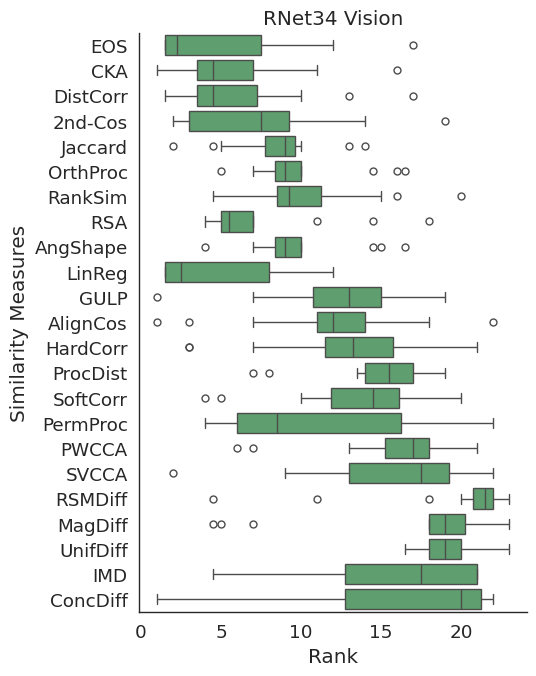

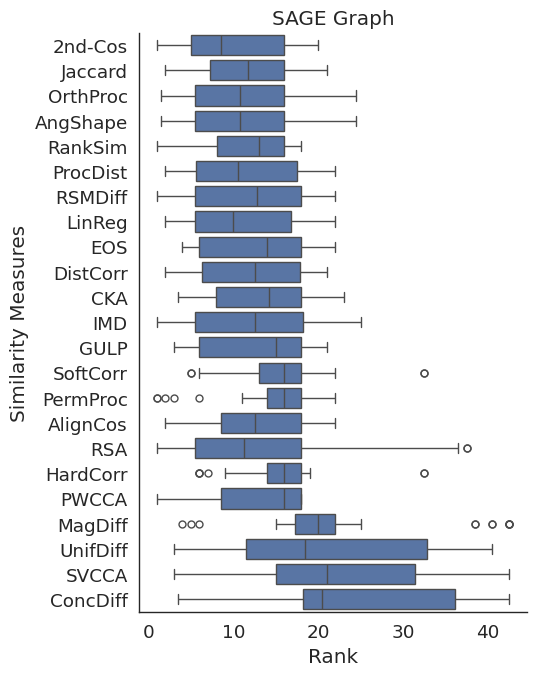

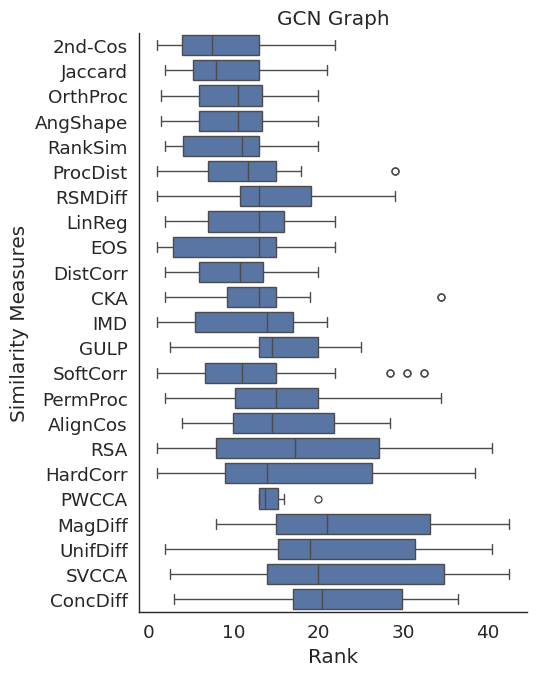

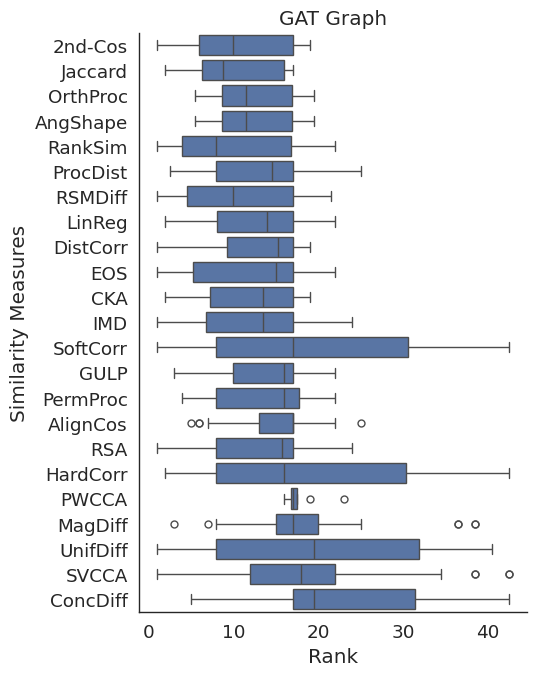

In [170]:
plot_data = pd.merge(data, avg_ranks).sort_values(by=["med_rank"])
for mod in plot_data.Modality.unique():
    for arch in plot_data["Arch."].unique():
        subdata = plot_data[(plot_data.Modality == mod) & (plot_data["Arch."] == arch)]
        if len(subdata) == 0:
            continue

        g = sns.catplot(
            data=plot_data[(plot_data.Modality == mod) & (plot_data["Arch."] == arch)],
            x="rank",
            y="Sim Meas.",
            hue="Modality",
            kind="box",
            height=7,
            aspect=0.8,
            col="Arch.",
            palette={"Language": "C1", "Vision": "C2", "Graph": "C0"},
            legend=False
        )
        ax = g.axes[0, 0]
        ax.set_xlabel("Rank")
        ax.set_ylabel("Similarity Measures")

        ax.set_title(f"{arch} {mod}")
        # g.savefig(BASE_PATH / "figs" / f"aggregated_ver_{mod}.pdf", bbox_inches="tight")

In [190]:
data["Arch."].unique()

array(['RNet101', 'GCN', 'GAT', 'SAGE', 'ViT_B32', 'BERT', 'RNet34',
       'RNet18', 'ViT_L32', 'VGG11', 'VGG19', nan], dtype=object)

/root/similaritybench/experiments/figs/aggregated_ver_VGGs.pdf
/root/similaritybench/experiments/figs/aggregated_ver_ResNets.pdf


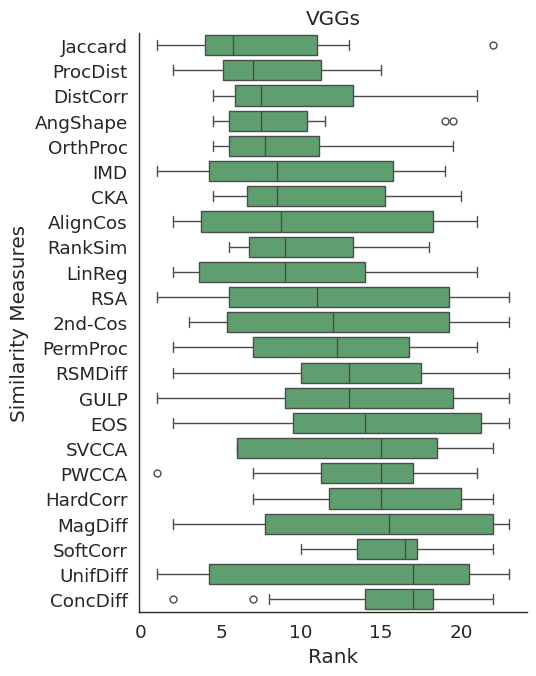

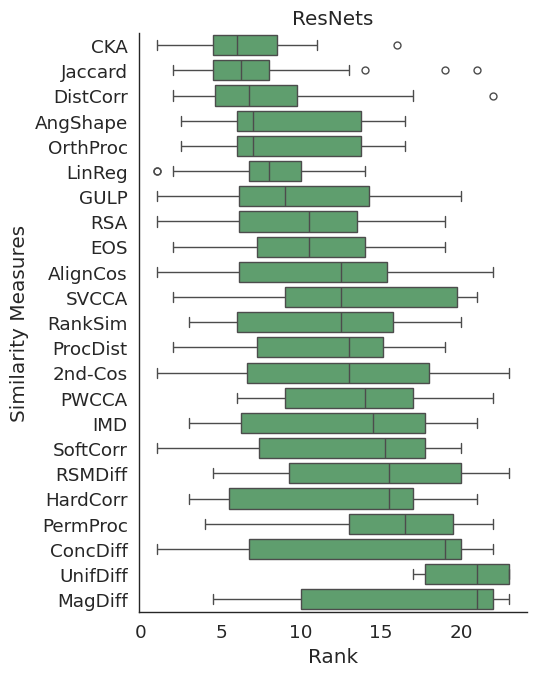

In [227]:
for archs, fname in [
    (["VGG11", "VGG19"], "VGGs"),
    (["RNet18", "RNet34", "RNet101"], "ResNets")
    ]:
    avg_ranks = data[(data["Arch."].isin(archs))].groupby(["Modality", "Sim Meas."])["rank"].agg(["mean", "median"]).reset_index()
    # avg_ranks = data[data["Arch."].isin(archs)].groupby(["Modality", "Sim Meas."])["rank"].agg(["mean", "median"]).reset_index()
    avg_ranks = avg_ranks.rename(columns={"mean": "avg_rank", "median": "med_rank"})
    avg_ranks

    plot_data = pd.merge(data, avg_ranks).sort_values(by="med_rank")
    subdata = plot_data[(plot_data.Modality == "Vision") & (plot_data["Arch."].isin(archs))]

    g = sns.catplot(
        data=subdata,
        x="rank",
        y="Sim Meas.",
        hue="Modality",
        kind="box",
        height=7,
        aspect=0.8,
        col="Modality",
        palette={"Language": "C1", "Vision": "C2", "Graph": "C0"},
        legend=False
    )
    ax = g.axes[0, 0]
    ax.set_xlabel("Rank")
    ax.set_ylabel("Similarity Measures")

    ax.set_title(f"{fname}")
    g.savefig(BASE_PATH / "figs" / f"aggregated_ver_{fname}.pdf", bbox_inches="tight")
    print(BASE_PATH / "figs" / f"aggregated_ver_{fname}.pdf")

### Per Test

Uses only the AUPRC und spearman results

In [93]:
print(data["Eval."].unique())
data.head()

['Spearman' 'AUPRC']


,index,Sim Meas.,Eval.,value,Modality,Arch.,representation_dataset,identifier,Scenario,Dataset,Functional Similarity Measure,corr,pval,model,rank
8176,928,2nd-Cos,Spearman,0.286298,Vision,RNet101,ImageNet100,Normal,JSD Corr.,IN100,JSD,0.286298,0.056569,agg,12.0
2353,1203,2nd-Cos,Spearman,0.966667,Graph,GCN,ogbn-arxiv,MultiLayer,Layer Mono.,arXiv,NaN,NaN,NaN,GRAPHS_GCN_ogbn-arxiv_MultiLayer_0,5.0
3877,2727,2nd-Cos,Spearman,1.000000,Graph,GAT,cora,MultiLayer,Layer Mono.,Cora,NaN,NaN,NaN,GRAPHS_GAT_cora_MultiLayer_2,16.0
5621,4471,2nd-Cos,AUPRC,0.732973,Graph,GAT,cora,Normal,Random Labels,Cora,NaN,NaN,NaN,agg,3.0
8904,1656,2nd-Cos,AUPRC,0.913679,Vision,RNet101,Gauss_Off_ImageNet100DataModule,GaussNoise,Augmentation,IN100,NaN,NaN,NaN,agg,1.0


In [94]:
avg_ranks = data.groupby(["Modality", "Sim Meas.", "Scenario"])["rank"].agg(["mean", "median"]).reset_index()
avg_ranks = avg_ranks.rename(columns={"mean": "avg_rank", "median": "med_rank"})
avg_ranks

,Modality,Sim Meas.,Scenario,avg_rank,med_rank
0,Graph,2nd-Cos,Acc Corr.,14.000000,14.5
1,Graph,2nd-Cos,Augmentation,3.777778,3.0
2,Graph,2nd-Cos,Disagr. Corr.,10.400000,8.5
3,Graph,2nd-Cos,JSD Corr.,9.300000,9.0
4,Graph,2nd-Cos,Layer Mono.,12.053846,13.0
...,...,...,...,...,...
475,Vision,UnifDiff,Disagr. Corr.,6.666667,2.0
476,Vision,UnifDiff,JSD Corr.,15.000000,19.0
477,Vision,UnifDiff,Layer Mono.,18.340000,19.0
478,Vision,UnifDiff,Random Labels,19.285714,21.0


In [95]:
from IPython.display import display

In [96]:
plot_data = pd.merge(data, avg_ranks).sort_values(by=["med_rank"])
for test in plot_data.Scenario.unique():
    for mod in plot_data.Modality.unique():
        subplot_data = plot_data[(plot_data.Scenario == test) & (plot_data.Modality == mod)]
        # --------------------------- V1 ---------------------------------------
        # g = sns.catplot(
        #     data=plot_data[(plot_data.Scenario == test) & (plot_data.Modality == mod)],
        #     x="rank",
        #     y="Sim Meas.",
        #     hue="Modality",
        #     kind="swarm",
        #     height=7,
        #     aspect=0.8,
        #     col="Modality",
        #     palette={"Language": "C1", "Vision": "C2", "Graph": "C0"},
        #     legend=False
        # )

        # --------------------------- V2 ---------------------------------------
        # fig, ax = plt.subplots(1, 1, figsize=(7, 7*0.8))
        # g = sns.boxplot(
        #     data=plot_data[(plot_data.Scenario == test) & (plot_data.Modality == mod)],
        #     x="rank",
        #     y="Sim Meas.",
        #     hue="Modality",
        #     # height=7,
        #     # aspect=0.8,
        #     # col="Modality",
        #     palette={"Language": "C1", "Vision": "C2", "Graph": "C0"},
        #     # legend=False,
        #     ax=ax
        # )
        # g = sns.stripplot(
        #     data=plot_data[(plot_data.Scenario == test) & (plot_data.Modality == mod)],
        #     x="rank",
        #     y="Sim Meas.",
        #     hue="Modality",
        #     size=5,
        #     # height=7,
        #     # aspect=0.8,
        #     # col="Modality",
        #     palette={"Language": "C2", "Vision": "C3", "Graph": "C1"},
        #     # legend=False,
        #     ax=ax
        # )
        # ------------------------------------------------------------------------

        # # ax = g.axes[0, 0]
        # for i in range(len(subplot_data["Sim Meas."].unique())):
        #     if i % 2 == 0:
        #         ax.fill_between([0, 23], [-0.5 + i, -0.5 + i], [0.5 + i, 0.5 + i], color="gray", alpha=0.2)
        # ax.set_xlabel("Rank")
        # ax.set_ylabel("Similarity Measures")
        # if mod == "Graph":
        #     ax.set_title(f"{test} (Graphs)")
        # else:
        #     ax.set_title(f"{test} ({mod})")
        # g.savefig(BASE_PATH / "figs" / f"aggregated_ver_{mod}.pdf", bbox_inches="tight")

        display(subplot_data.head(2))

        break
    break

,index,Sim Meas.,Eval.,value,Modality,Arch.,representation_dataset,identifier,Scenario,Dataset,Functional Similarity Measure,corr,pval,model,rank,avg_rank,med_rank
437,600,AlignCos,AUPRC,0.994444,Language,BERT,sst2_mem_rate0,RandomLabels_75,Random Labels,SST2,NaN,NaN,NaN,agg,1.0,1.25,1.25
508,71,AlignCos,AUPRC,1.000000,Language,BERT,mnli_mem_rate0,RandomLabels_75,Random Labels,MNLI,NaN,NaN,NaN,agg,1.5,1.25,1.25


In [97]:
plot_data = pd.merge(data, avg_ranks).sort_values(by=["med_rank"])
plot_data.loc[plot_data.Scenario.isin(["Acc Corr.", "JSD Corr.", "Disagr. Corr."]), "Type"] = "Grounding by Prediction"
plot_data.loc[plot_data.Scenario.isin(["Random Labels", "Shortcuts", "Augmentation", "Layer Mono."]), "Type"] = (
        "Grounding by Design"
    )
column_order = ["Acc Corr.", "JSD Corr.", "Disagr. Corr.", "Random Labels", "Shortcuts", "Augmentation", "Layer Mono."]

# -------------------------------------------
# Create pivot with mean values. The values are converted to string for combination with stddev
pivot = pd.pivot_table(
    plot_data,
    index="Sim Meas.",
    columns=["Type", "Scenario", "Eval.", "Modality"],
    values="value",
    aggfunc="mean",
)
pivot = pivot.sort_values(by="Sim Meas.")
pivot = pivot.reindex(column_order, axis="columns", level="Scenario")
pivot = pivot.reindex(["Grounding by Prediction", "Grounding by Design"], axis="columns", level="Type")
pivot

unpivot = pivot.unstack().reset_index()  # values will be in col "0"
unpivot.loc[:, 1] = unpivot.loc[:, 0].astype("str")
unpivot.loc[:, 1] = unpivot.loc[:, 0].apply(lambda x: str(round(x, 2)))
pivot_mean = unpivot.pivot(index="Sim Meas.",
    columns=["Type", "Scenario", "Eval.", "Modality"],
    values=1,)
unpivot
pivot_mean

# display(pivot.head())

# -----------------------------------------------
# Create pivot with stddev values.
pivot = pd.pivot_table(
    plot_data,
    index="Sim Meas.",
    columns=["Type", "Scenario", "Eval.", "Modality"],
    values="value",
    aggfunc="std",
)
pivot = pivot.sort_values(by="Sim Meas.")
pivot = pivot.reindex(column_order, axis="columns", level="Scenario")
pivot = pivot.reindex(["Grounding by Prediction", "Grounding by Design"], axis="columns", level="Type")
pivot

unpivot = pivot.unstack().reset_index()  # values will be in col "0"
unpivot.loc[:, 1] = unpivot.loc[:, 0].astype("str")
unpivot.loc[:, 1] = unpivot.loc[:, 0].apply(lambda x: str(round(x, 2)))
pivot_std = unpivot.pivot(index="Sim Meas.",
    columns=["Type", "Scenario", "Eval.", "Modality"],
    values=1,)
unpivot
pivot_std
# display(pivot.head())

# -----------------------------------------
# Combine mean with stddev
pivot_comb = pivot_mean + r"$\pm$" + pivot_std



# -----------------------------------------
# Bold best metric scores
def floatify(s: str) -> str:
    """Turn a string like '-0.10$\pm$0.2' into '-0.10'"""
    return s[:s.find("$")]

def separate_significance_indicator(s: str) -> str:
    """Turn a string like '-0.10$^{\phantom{**}}$' into '$^{\phantom{**}}$'"""
    return s[s.find("$"):]


for column in pivot_comb.columns:
    col = pivot_comb.loc[:, column].apply(floatify).astype("float").copy()
    stddev = pivot_comb.loc[:, column].apply(separate_significance_indicator)
    idx = col == col.max()
    new_col = col.apply(lambda x: f"{x:.2f}").map(lambda s: r"\textbf{" + s + "}") + stddev.map(lambda s: r"\textbf{" + s + "}")
    pivot_comb.loc[idx, column] = new_col

pivot_comb

Type              Grounding by Prediction                                   \
Scenario                        Acc Corr.                                    
Eval.                            Spearman                                    
Modality                            Graph                         Language   
Sim Meas.                                                                    
2nd-Cos                    -0.04$\pm$0.21                    0.02$\pm$0.39   
AlignCos                    0.02$\pm$0.23                    0.13$\pm$0.16   
AngShape                    0.01$\pm$0.22                    0.07$\pm$0.29   
CKA                         0.01$\pm$0.17                    0.06$\pm$0.17   
ConcDiff                    -0.05$\pm$0.2                    0.06$\pm$0.08   
DistCorr                    0.06$\pm$0.16                    0.03$\pm$0.18   
EOS                         0.09$\pm$0.19                   -0.18$\pm$0.29   
GULP                        -0.02$\pm$0.2                   -0.18$\pm$0.25   
HardCorr                    0.07$\pm$0.18                   -0.14$\pm$0.26   
IMD                        -0.05$\pm$0.14                   -0.16$\pm$0.14   
Jaccard                    -0.06$\pm$0.12                   -0.02$\pm$0.27   
LinReg                     -0.05$\pm$0.16                    -0.1$\pm$0.39   
MagDiff                     0.01$\pm$0.18                    0.04$\pm$0.25   
OrthProc                    0.01$\pm$0.22                    0.07$\pm$0.29   
PWCCA                      -0.04$\pm$0.16                   -0.16$\pm$0.24   
PermProc                    0.09$\pm$0.25                    -0.0$\pm$0.13   
ProcDist                    0.04$\pm$0.23                    0.19$\pm$0.13   
RSA        \textbf{0.10}\textbf{$\pm$0.3}                   -0.11$\pm$0.17   
RSMDiff                    -0.04$\pm$0.19  \textbf{0.25}\textbf{$\pm$0.07}   
RankSim                    -0.01$\pm$0.19                    0.03$\pm$0.16   
SVCCA                       -0.09$\pm$0.1                    0.12$\pm$0.28   
SoftCorr                    0.08$\pm$0.17                   -0.11$\pm$0.31   
UnifDiff                   -0.07$\pm$0.08                    0.24$\pm$0.14   

Type                                                                         \
Scenario                                                          JSD Corr.   
Eval.                                                              Spearman   
Modality                            Vision                            Graph   
Sim Meas.                                                                     
2nd-Cos                     -0.09$\pm$0.14                    0.25$\pm$0.25   
AlignCos                    -0.08$\pm$0.14                     0.15$\pm$0.2   
AngShape                     0.05$\pm$0.12                    0.25$\pm$0.31   
CKA                          0.01$\pm$0.21                    0.19$\pm$0.29   
ConcDiff                     0.02$\pm$0.18                   -0.02$\pm$0.12   
DistCorr                    -0.01$\pm$0.19                     0.25$\pm$0.3   
EOS                          0.05$\pm$0.22                    0.09$\pm$0.21   
GULP                         0.02$\pm$0.14                    0.14$\pm$0.15   
HardCorr                     0.07$\pm$0.17                    0.23$\pm$0.31   
IMD                         -0.06$\pm$0.17                   -0.03$\pm$0.22   
Jaccard                     -0.03$\pm$0.15  \textbf{0.28}\textbf{$\pm$0.16}   
LinReg                        0.06$\pm$0.1                    0.18$\pm$0.29   
MagDiff                     -0.03$\pm$0.11                   -0.03$\pm$0.12   
OrthProc                     0.05$\pm$0.12                    0.25$\pm$0.31   
PWCCA                        0.08$\pm$0.36                    0.02$\pm$0.22   
PermProc                     -0.0$\pm$0.16                     0.01$\pm$0.3   
ProcDist                     0.09$\pm$0.06                    0.01$\pm$0.31   
RSA                         -0.05$\pm$0.19                    0.27$\pm$0.19  

In [99]:
styled = pd.io.formats.style.Styler(
    pivot_comb,
    precision=2,
)

# Highlight top value
# latex_str = styled.highlight_max(axis=0, props="textbf:--rwrap;").to_latex(
#     hrules=True,
#     position="t",
#     label="tab:result_overview",
# )
latex_str = styled.to_latex(hrules=True, position="t", label="tab:results_agg_per_test",)


# ----- Manual modifications --------
latex_str = latex_str.split("\n")

# # Center headers
# pattern = r"\{r\}"
# replacement = r"{c}"
# latex_str = [re.sub(pattern, replacement, line) if i in [5, 6, 7] else line for i, line in enumerate(latex_str)]

# # Remove measure row
# latex_str.pop(11)

# # Add vertical bars
# line_no = 2
# # line_no = 3
# mod_line = latex_str[line_no][:17] + "".join(["|rrr"] * 6) + "}"
# latex_str[line_no] = mod_line

# Make every second row gray
latex_str = [
    r"\rowcolor{Gray}" + line if i >= 12 and (i - 12) % 2 == 0 else line for i, line in enumerate(latex_str[:-4])
] + latex_str[-4:]
latex_str = "\n".join(latex_str)
print(latex_str)

\begin{table}[t]
\label{tab:results_agg_per_test}
\begin{tabular}{llllllllllllllllllllll}
\toprule
Type & \multicolumn{9}{r}{Grounding by Prediction} & \multicolumn{12}{r}{Grounding by Design} \\
Scenario & \multicolumn{3}{r}{Acc Corr.} & \multicolumn{3}{r}{JSD Corr.} & \multicolumn{3}{r}{Disagr. Corr.} & \multicolumn{3}{r}{Random Labels} & \multicolumn{3}{r}{Shortcuts} & \multicolumn{3}{r}{Augmentation} & \multicolumn{3}{r}{Layer Mono.} \\
Eval. & \multicolumn{3}{r}{Spearman} & \multicolumn{3}{r}{Spearman} & \multicolumn{3}{r}{Spearman} & \multicolumn{3}{r}{AUPRC} & \multicolumn{3}{r}{AUPRC} & \multicolumn{3}{r}{AUPRC} & \multicolumn{3}{r}{Spearman} \\
Modality & Graph & Language & Vision & Graph & Language & Vision & Graph & Language & Vision & Graph & Language & Vision & Graph & Language & Vision & Graph & Language & Vision & Graph & Language & Vision \\
Sim Meas. &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
2nd-Cos & -0.04$\pm$0.21 & 0.02$\pm$0.39 & -0

In [101]:
plot_data = pd.merge(data, avg_ranks).sort_values(by=["med_rank"])
plot_data.loc[plot_data.Scenario.isin(["Acc Corr.", "JSD Corr.", "Disagr. Corr."]), "Type"] = "Grounding by Prediction"
plot_data.loc[plot_data.Scenario.isin(["Random Labels", "Shortcuts", "Augmentation", "Layer Mono."]), "Type"] = (
        "Grounding by Design"
    )
column_order = ["Acc Corr.", "JSD Corr.", "Disagr. Corr.", "Random Labels", "Shortcuts", "Augmentation", "Layer Mono."]

# -------------------------------------------
# Create pivot with mean ranks. The values are converted to string for combination with stddev
pivot = pd.pivot_table(
    plot_data,
    index="Sim Meas.",
    columns=["Modality", "Type", "Scenario", "Eval."],
    values="rank",
    aggfunc="mean",
)
pivot = pivot.sort_values(by="Sim Meas.")
pivot = pivot.reindex(column_order, axis="columns", level="Scenario")
pivot = pivot.reindex(["Grounding by Prediction", "Grounding by Design"], axis="columns", level="Type")
pivot


Modality                    Graph                           \
Type      Grounding by Prediction                            
Scenario                Acc Corr.  JSD Corr. Disagr. Corr.   
Eval.                    Spearman   Spearman      Spearman   
Sim Meas.                                                    
2nd-Cos                 14.000000   9.300000     10.400000   
AlignCos                11.800000  12.500000     13.400000   
AngShape                12.050000   8.250000      7.950000   
CKA                     10.700000  10.700000     11.000000   
ConcDiff                14.200000  16.600000     17.400000   
DistCorr                 9.000000   9.500000      9.600000   
EOS                      7.700000  13.300000     13.800000   
GULP                    11.800000  12.400000     14.200000   
HardCorr                10.300000   9.500000      8.900000   
IMD                     13.538462  17.000000     17.923077   
Jaccard                 15.400000   7.500000      8.600000   
LinReg                  14.400000  10.100000     11.100000   
MagDiff                 11.000000  16.900000     17.400000   
OrthProc                11.950000   8.350000      8.050000   
PWCCA                   14.750000  16.500000     13.250000   
PermProc                 8.400000  14.600000     12.000000   
ProcDist                11.400000  13.900000     12.800000   
RSA                     10.600000   6.400000      5.000000   
RSMDiff                 12.538462  17.615385     15.307692   
RankSim                 13.400000   8.000000      9.300000   
SVCCA                   16.000000  13.300000     14.300000   
SoftCorr                 8.700000   9.200000      8.400000   
UnifDiff                14.300000  15.000000     14.800000   

Modality                                                           \
Type      Grounding by Design                                       
Scenario        Random Labels  Shortcuts Augmentation Layer Mono.   
Eval.                   AUPRC      AUPRC        AUPRC    Spearman   
Sim Meas.                                                           
2nd-Cos              6.777778   4.500000     3.777778   12.053846   
AlignCos             9.000000   7.611111    11.666667   17.554688   
AngShape            11.055556   8.888889    11.055556   12.230769   
CKA                  7.722222  10.000000    10.222222   15.046154   
ConcDiff            12.944444  17.777778    18.111111   27.992308   
DistCorr             8.166667   9.111111     7.000000   14.084615   
EOS                 19.555556  14.333333    14.111111   10.130769   
GULP                19.888889  17.111111    15.888889   13.069231   
HardCorr            11.388889  14.833333    13.555556   21.415385   
IMD                  8.444444  10.222222    13.333333   10.350000   
Jaccard             13.333333   6.500000     4.666667   10.915385   
LinReg              12.777778  10.500000    11.333333   12.500000   
MagDiff             17.333333  18.000000    16.111111   24.615385   
OrthProc            11.055556   8.888889    11.055556   12.230769   
PWCCA                     NaN        NaN          NaN   14.105263   
PermProc            10.888889  17.555556    13.444444   16.207692   
ProcDist             7.944444   8.555556     8.000000   12.507692   
RSA                 11.111111  10.000000    13.444444   19.123077   
RSMDiff              5.666667   8.055556     5.500000   12.760000   
RankSim             11.333333   7.500000     6.444444   10.738462   
SVCCA               11.222222  15.000000    15.222222   26.453846   
SoftCorr            12.277778  13.166667    14.666667   19.846154   
UnifDiff            13.111111  14.888889    14.388889   24.946154   

Modality                 Language                          ...  \
Type      Grounding by Prediction                          ...   
Scenario                Acc Corr. JSD Corr. Disagr. Corr.  ...   
Eval.                    Spearman  Spearman      Spearman  ...   
Sim Meas.                                                  ...   


In [162]:
for mod in data.Modality.unique():
    print(mod)
    subdata = pivot.loc[:, mod]
    # display(subdata.head(3))
    styled = pd.io.formats.style.Styler(
        subdata,
        precision=1,
    )

    # Highlight top value
    latex_str = styled.highlight_min(axis=0, props="textbf:--rwrap;").to_latex(
        hrules=True,
        position="t",
        label="tab:result_overview",
    )
    latex_str = styled.to_latex(hrules=True, position="t", label="tab:results_agg_per_test",)


    # ----- Manual modifications --------
    latex_str = latex_str.split("\n")

    # # Center headers
    # pattern = r"\{r\}"
    # replacement = r"{c}"
    # latex_str = [re.sub(pattern, replacement, line) if i in [5, 6, 7] else line for i, line in enumerate(latex_str)]

    # Remove measure row
    latex_str.pop(7)

    # Remove eval measure row
    latex_str.pop(6)

    # # Add vertical bars
    # line_no = 2
    # # line_no = 3
    # mod_line = latex_str[line_no][:17] + "".join(["|rrr"] * 6) + "}"
    # latex_str[line_no] = mod_line

    # Make every second row gray
    latex_str = [
        r"\rowcolor{Gray}" + line if i >= 7 and (i - 7) % 2 == 0 else line for i, line in enumerate(latex_str[:-4])
    ] + latex_str[-4:]
    latex_str = "\n".join(latex_str)
    print(latex_str)

Vision
\begin{table}[t]
\label{tab:results_agg_per_test}
\begin{tabular}{lrrrrrrr}
\toprule
Type & \multicolumn{3}{r}{Grounding by Prediction} & \multicolumn{4}{r}{Grounding by Design} \\
Scenario & Acc Corr. & JSD Corr. & Disagr. Corr. & Random Labels & Shortcuts & Augmentation & Layer Mono. \\
\midrule
\rowcolor{Gray}2nd-Cos & 15.7 & 13.1 & 11.9 & 17.3 & \textbf{5.8} & 6.3 & 6.6 \\
AlignCos & 16.1 & 12.0 & 8.4 & 13.2 & \textbf{5.8} & \textbf{4.7} & 11.8 \\
\rowcolor{Gray}AngShape & 8.8 & 9.1 & 12.4 & 8.9 & 6.1 & 9.9 & 8.3 \\
CKA & 10.1 & 11.0 & 8.7 & 6.9 & \textbf{5.8} & 8.6 & 6.6 \\
\rowcolor{Gray}ConcDiff & 13.1 & 17.6 & 17.0 & 7.0 & 20.6 & 12.6 & 20.1 \\
DistCorr & 12.7 & 10.4 & 9.0 & 6.3 & \textbf{5.8} & 10.8 & 6.5 \\
\rowcolor{Gray}EOS & 12.0 & 11.4 & 14.6 & 14.9 & 10.8 & 7.3 & \textbf{5.0} \\
GULP & 11.4 & 10.1 & 14.0 & 16.6 & 9.1 & 7.1 & 9.4 \\
\rowcolor{Gray}HardCorr & 9.7 & 12.6 & 13.3 & 12.4 & 12.0 & 17.4 & 11.8 \\
IMD & 14.1 & 9.3 & 7.0 & 5.7 & 15.9 & 13.9 & 21.0 \\
\rowco

tabelle mit ranks als index und entries als metrics

"rank" column: Rank des measures grouped by ["domain", "Setting", "Dataset", "architecture", "model"]

In [160]:
# plot_data = pd.merge(data.copy(), data.groupby(["Modality", "Scenario", "Sim Meas."])["rank"].mean().groupby(["Modality", "Scenario",]).rank().reset_index().rename(columns={"rank": "rank_per_test_and_mod"}))
# display(plot_data)
# plot_data.drop_duplicates(subset=["Modality", "Scenario", "Sim Meas."])

# for mod in data.Modality.unique():
#     subdata = plot_data.loc[plot_data.Modality == mod]
#     pd.pivot(subdata, index="rank_per_test_and_mod", columns=["Scenario"], values="Sim Meas.")
# # data.groupby(["Modality", "Scenario"])["avg_rank"].agg(["mean", "median"]).reset_index()

# # avg_ranks.groupby(["Modality", "Sim Meas.", "Scenario"])["avg_rank"].rank()

## Rebuttal PGNN tables

In [85]:
data = graph_data.copy()

data = data.rename(
    columns={
        "functional_similarity_measure": "Functional Similarity Measure",
        "similarity_measure": "Representational Similarity Measure",
        "quality_measure": "Quality Measure",
    }
)

idx = data.Setting == "correlation"
data.loc[idx, "value"] = data.loc[idx, "corr"]

idx = (data.Setting == "correlation") & (data["Functional Similarity Measure"] == "AbsoluteAccDiff")
data.loc[idx, "Setting"] = "acc_corr"

idx = (data.Setting == "correlation") & (data["Functional Similarity Measure"] == "Disagreement")
data.loc[idx, "Setting"] = "disagr_corr"

data.loc[:, "Representational Similarity Measure"] = data["Representational Similarity Measure"].map(
    measure_to_abbrv
)
data.loc[:, "architecture"] = data["architecture"].map(
    {
        "BERT-L": "BERT",
        "GCN": "GCN",
        "GAT": "GAT",
        "GraphSAGE": "SAGE",
        "VGG11": "VGG11",
        "VGG19": "VGG19",
        "ResNet18": "RNet18",
        "ResNet34": "RNet34",
        "ResNet101": "RNet101",
        "ViT_B32": "ViT_B32",
        "ViT_L32": "ViT_L32",
        "PGNN": "P-GNN",
    }
)
data.loc[:, "domain"] = data["domain"].map({"NLP": "Text", "GRAPHS": "Graph", "VISION": "Vision"})
data.loc[:, "Dataset"] = data["Dataset"].map(
    {
        "mnli_aug_rate0": "MNLI",
        "mnli_mem_rate0": "MNLI",
        "mnli": "MNLI",
        "sst2_sc_rate0558": "SST2",
        "sst2_mem_rate0": "SST2",
        "mnli_sc_rate0354": "MNLI",
        "sst2_aug_rate0": "SST2",
        "sst2": "SST2",
        "flickr": "flickr",
        "ogbn-arxiv": "arXiv",
        "cora": "Cora",
        "in100": "IN100",
    }
)
data.loc[:, "Setting"] = data["Setting"].map(
    {
        "aug": "Augmentation",
        "mem": "Random Labels",
        "correlation": "JSD Corr.",
        "acc_corr": "Acc Corr.",
        "disagr_corr": "Disagr. Corr.",
        "mono": "Layer Mono.",
        "sc": "Shortcuts",
    }
)
column_order = ["Acc Corr.", "Disagr. Corr.", "JSD Corr.", "Random Labels", "Shortcuts", "Augmentation", "Layer Mono."]
data.loc[:, "Setting"] = pd.Categorical(
    data["Setting"],
    categories=column_order,
    ordered=True,
)
data.loc[:, "Quality Measure"] = data["Quality Measure"].map(
    {"violation_rate": "Conformity Rate", "AUPRC": "AUPRC", "spearmanr": "Spearman", "correlation": "Spearman"}
)
data.loc[data["Quality Measure"] == "Conformity Rate", "value"] = (
    1 - data.loc[data["Quality Measure"] == "Conformity Rate", "value"]
)  # must be run in conjunction with the above renaming

data = data.rename(
    columns={
        "domain": "Modality",
        "architecture": "Arch.",
        "Representational Similarity Measure": "Sim Meas.",
        "Quality Measure": "Eval.",
        "Setting": "Test",
    }
)
data.loc[data.Test.isin(["Acc Corr.", "Disagr. Corr.", "JSD Corr."]), "Type"] = "Grounding by Prediction"
data.loc[data.Test.isin(["Random Labels", "Shortcuts", "Augmentation", "Layer Mono."]), "Type"] = (
    "Grounding by Design"
)

data = data[(~data["Eval."].isna()) & (data["Dataset"] == "Cora") & (data["Test"].isin(["Acc Corr.", "Disagr. Corr.", "JSD Corr.", "Layer Mono."]))]

pivot = pd.pivot_table(
    data,
    index="Sim Meas.",
    columns=["Type", "Test", "Eval.", "Modality", "Dataset", "Arch."],
    values="value",
)
pivot = pivot.sort_values(by="Sim Meas.")
pivot = pivot.reindex(column_order, axis="columns", level="Test")
pivot = pivot.reindex(["Grounding by Prediction", "Grounding by Design"], axis="columns", level="Type")
pivot = pivot.reindex(["GAT", "GCN", "SAGE", "P-GNN"], axis="columns", level="Arch.")
pivot

# turn vals into string
unpivot = pivot.unstack().reset_index()  # values will be in col "0"
unpivot.loc[:, 1] = unpivot.loc[:, 0].astype("str")
unpivot.loc[:, 1] = unpivot.loc[:, 0].apply(lambda x: f"{round(x, 2):.2f}")
pivot = unpivot.pivot(index="Sim Meas.",
    columns=["Type", "Test", "Eval.", "Modality", "Dataset", "Arch."],
    values=1,)
unpivot


for column in pivot.columns:
    col = pivot.loc[:, column].astype("float")
    idx = col == col.max()
    pivot.loc[idx, column] = pivot.loc[idx, column].apply(lambda s: r"\textbf{" + s + "}")


# add significance indicators
idx = data["Dataset"].isin(["Cora"]) & data.Test.isin(["Acc Corr.", "Disagr. Corr.", "JSD Corr."])
data_corr = data.loc[idx].copy()


def pval_str(pval):
    # if pval == pd.notna
    if isinstance(pval, float):
        if pval <= 0.01:
            return r"$^{**}$"
            # return r"$^{\dagger}$"
        if pval <= 0.05:
            return r"$^{*\phantom{*}}$"
            # return r"$^{\ddagger}$"
    return r"$^{\phantom{**}}$"

data_corr["val_comb"] = data_corr["value"].apply(lambda x: f"{round(x, ndigits=2):.2f}") + data_corr["pval"].apply(pval_str)
data_corr

pivot_corr = data_corr.drop_duplicates(
    subset=[
        "Sim Meas.",
        "Eval.",
        "model",
        "Modality",
        "Arch.",
        "representation_dataset",
        "identifier",
        "Test",
        "Dataset",
        "Functional Similarity Measure",
        "Type"
        ]).pivot(
    index="Sim Meas.",
    columns=["Type", "Test", "Eval.", "Modality", "Dataset", "Arch."],
    values=["val_comb"],
).sort_values(
    by="Sim Meas."
).reindex(
    column_order, axis="columns", level="Test"
).reindex(
    ["Graph", "Text", "Vision"], axis="columns", level="Modality"
).loc[:, "val_comb"]
display(pivot_corr.head(3))


def floatify(s: str) -> str:
    """Turn a string like '-0.10$^{\phantom{**}}$' into '-0.10'"""
    return s[:s.find("$")]

def separate_significance_indicator(s: str) -> str:
    """Turn a string like '-0.10$^{\phantom{**}}$' into '$^{\phantom{**}}$'"""
    return s[s.find("$"):]


for column in pivot_corr.columns:
    col = pivot_corr.loc[:, column].apply(floatify).astype("float")
    identifiers = pivot_corr.loc[:, column].apply(separate_significance_indicator)
    idx = col == col.max()
    new_col = col.apply(lambda x: f"{x:.2f}").apply(lambda s: r"\textbf{" + s + "}") + identifiers
    pivot_corr.loc[idx, column] = new_col


pivot.loc[:, ("Grounding by Prediction")] = pivot_corr
pivot

Type      Grounding by Prediction                          \
Test                    Acc Corr.                           
Eval.                    Spearman                           
Modality                    Graph                           
Dataset                      Cora                           
Arch.                         GCN                     GAT   
Sim Meas.                                                   
2nd-Cos    -0.10$^{\phantom{**}}$  -0.11$^{\phantom{**}}$   
AlignCos   -0.33$^{*\phantom{*}}$  -0.29$^{\phantom{**}}$   
AngShape    0.15$^{\phantom{**}}$  -0.12$^{\phantom{**}}$   

Type                                                      \
Test                                                       
Eval.                                                      
Modality                                                   
Dataset                                                    
Arch.                        SAGE                  P-GNN   
Sim Meas.                                                  
2nd-Cos     0.04$^{\phantom{**}}$  0.15$^{*\phantom{*}}$   
AlignCos    0.13$^{\phantom{**}}$  0.05$^{\phantom{**}}$   
AngShape   -0.29$^{\phantom{**}}$            0.20$^{**}$   

Type                                                       \
Test                Disagr. Corr.                           
Eval.                    Spearman                           
Modality                    Graph                           
Dataset                      Cora                           
Arch.                         GCN                     GAT   
Sim Meas.                                                   
2nd-Cos               0.40$^{**}$   0.30$^{*\phantom{*}}$   
AlignCos   -0.08$^{\phantom{**}}$  -0.05$^{\phantom{**}}$   
AngShape              0.62$^{**}$   0.05$^{\phantom{**}}$   

Type                                                     \
Test                                                      
Eval.                                                     
Modality                                                  
Dataset                                                   
Arch.                       SAGE                  P-GNN   
Sim Meas.                                                 
2nd-Cos    0.25$^{\phantom{**}}$  0.15$^{*\phantom{*}}$   
AlignCos   0.27$^{\phantom{**}}$  0.21$^{\phantom{**}}$   
AngShape   0.16$^{\phantom{**}}$            0.31$^{**}$   

Type                                                     \
Test                   JSD Corr.                          
Eval.                   Spearman                          
Modality                   Graph                          
Dataset                     Cora                          
Arch.                        GCN                    GAT   
Sim Meas.                                                 
2nd-Cos              0.43$^{**}$            0.53$^{**}$   
AlignCos   0.02$^{\phantom{**}}$  0.17$^{\phantom{**}}$   
AngShape             0.70$^{**}$  0.28$^{\phantom{**}}$   

Type                                                      
Test                                                      
Eval.                                                     
Modality                                                  
Dataset                                                   
Arch.                       SAGE                   P-GNN  
Sim Meas.                                                 
2nd-Cos              0.54$^{**}$            -0.24$^{**}$  
AlignCos             0.38$^{**}$  -0.14$^{\phantom{**}}$  
AngShape   0.27$^{\phantom{**}}$            -0.25$^{**}$

Type              Grounding by Prediction                                  \
Test                            Acc Corr.                                   
Eval.                            Spearman                                   
Modality                            Graph                                   
Dataset                              Cora                                   
Arch.                                 GAT                             GCN   
Sim Meas.                                                                   
2nd-Cos            -0.11$^{\phantom{**}}$          -0.10$^{\phantom{**}}$   
AlignCos           -0.29$^{\phantom{**}}$          -0.33$^{*\phantom{*}}$   
AngShape           -0.12$^{\phantom{**}}$           0.15$^{\phantom{**}}$   
CKA                 0.02$^{\phantom{**}}$           0.16$^{\phantom{**}}$   
ConcDiff           -0.20$^{\phantom{**}}$           0.15$^{\phantom{**}}$   
DistCorr            0.03$^{\phantom{**}}$           0.01$^{\phantom{**}}$   
EOS                -0.05$^{\phantom{**}}$          -0.24$^{\phantom{**}}$   
GULP               -0.12$^{\phantom{**}}$                    -0.43$^{**}$   
HardCorr           -0.14$^{\phantom{**}}$           0.11$^{\phantom{**}}$   
IMD                -0.02$^{\phantom{**}}$          -0.11$^{\phantom{**}}$   
Jaccard            -0.16$^{\phantom{**}}$           0.02$^{\phantom{**}}$   
LinReg             -0.11$^{\phantom{**}}$           0.06$^{\phantom{**}}$   
MagDiff            -0.19$^{\phantom{**}}$           0.08$^{\phantom{**}}$   
OrthProc           -0.12$^{\phantom{**}}$           0.15$^{\phantom{**}}$   
PWCCA              -0.26$^{*\phantom{*}}$          -0.05$^{\phantom{**}}$   
PermProc           -0.26$^{\phantom{**}}$          -0.12$^{\phantom{**}}$   
ProcDist           -0.19$^{\phantom{**}}$           0.08$^{\phantom{**}}$   
RSA                -0.28$^{\phantom{**}}$          -0.27$^{\phantom{**}}$   
RSMDiff            -0.14$^{\phantom{**}}$          -0.19$^{\phantom{**}}$   
RankSim    \textbf{0.32}$^{*\phantom{*}}$          -0.00$^{\phantom{**}}$   
SVCCA              -0.19$^{\phantom{**}}$          -0.02$^{\phantom{**}}$   
SoftCorr            0.03$^{\phantom{**}}$  \textbf{0.18}$^{\phantom{**}}$   
UnifDiff           -0.09$^{\phantom{**}}$          -0.10$^{\phantom{**}}$   

Type                                                               \
Test                                                                
Eval.                                                               
Modality                                                            
Dataset                                                             
Arch.                                SAGE                   P-GNN   
Sim Meas.                                                           
2nd-Cos             0.04$^{\phantom{**}}$   0.15$^{*\phantom{*}}$   
AlignCos            0.13$^{\phantom{**}}$   0.05$^{\phantom{**}}$   
AngShape           -0.29$^{\phantom{**}}$             0.20$^{**}$   
CKA                -0.17$^{\phantom{**}}$  -0.01$^{\phantom{**}}$   
ConcDiff           -0.25$^{\phantom{**}}$             0.35$^{**}$   
DistCorr           -0.17$^{\phantom{**}}$   0.15$^{*\phantom{*}}$   
EOS                 0.08$^{\phantom{**}}$             0.27$^{**}$   
GULP                0.08$^{\phantom{**}}$             0.28$^{**}$   
HardCorr           -0.11$^{\phantom{**}}$             0.32$^{**}$   
IMD                -0.00$^{\phantom{**}}$  -0.16$^{*\phantom{*}}$   
Jaccard            -0.11$^{\phantom{**}}$   0.08$^{\phantom{**}}$   
LinReg             -0.21$^{\phantom{**}}$   0.06$^{\phantom{**}}$   
MagDiff            -0.13$^{\phantom{**}}$             0.36$^{**}$   
OrthProc           -0.29$^{\phantom{**}}$             0.20$^{**}$   
PWCCA               0.07$^{\phantom{**}}$   0.09$^{\phantom{**}}$   
PermProc   \textbf{0.18}$^{\phantom{**}}$    \textbf{0.47}$^{**}$   
ProcDist            0.01$^{\phantom{**}}$    \textbf{0.47}$^{**}$   
RSA                 0.04$^{\phant

In [94]:
len(data_corr), len(data_corr.drop_duplicates(subset=["Sim Meas.", "Eval.", "model", "Modality", "Arch.", "representation_dataset", "identifier", "Test", "Dataset", "Functional Similarity Measure", "Type"]))
# data_corr.drop_duplicates().groupby(["Arch.", "Dataset", "Eval.", "Test", "Sim Meas."]).count()[(data_corr.drop_duplicates().groupby(["Arch.", "Dataset", "Eval.", "Test", "Sim Meas."])["value"].count() > 1)]

# data_corr[(data_corr["Sim Meas."] == "IMD") & (data_corr["Dataset"] == "Cora") & (data_corr["Arch."] == "GAT") & (data_corr["Test"] == "JSD Corr.")]

latex_str = pivot.to_latex()
print(latex_str)

\begin{tabular}{lllllllllllllllllllll}
\toprule
Type & \multicolumn{12}{r}{Grounding by Prediction} & \multicolumn{8}{r}{Grounding by Design} \\
Test & \multicolumn{4}{r}{Acc Corr.} & \multicolumn{4}{r}{Disagr. Corr.} & \multicolumn{4}{r}{JSD Corr.} & \multicolumn{8}{r}{Layer Mono.} \\
Eval. & \multicolumn{4}{r}{Spearman} & \multicolumn{4}{r}{Spearman} & \multicolumn{4}{r}{Spearman} & \multicolumn{4}{r}{Conformity Rate} & \multicolumn{4}{r}{Spearman} \\
Modality & \multicolumn{4}{r}{Graph} & \multicolumn{4}{r}{Graph} & \multicolumn{4}{r}{Graph} & \multicolumn{4}{r}{Graph} & \multicolumn{4}{r}{Graph} \\
Dataset & \multicolumn{4}{r}{Cora} & \multicolumn{4}{r}{Cora} & \multicolumn{4}{r}{Cora} & \multicolumn{4}{r}{Cora} & \multicolumn{4}{r}{Cora} \\
Arch. & GAT & GCN & SAGE & P-GNN & GAT & GCN & SAGE & P-GNN & GAT & GCN & SAGE & P-GNN & GAT & GCN & SAGE & P-GNN & GAT & GCN & SAGE & P-GNN \\
Sim Meas. &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
2nd-Cos & -0.11$^{

## Survey Paper Summary

In [28]:
data

,index,Sim Meas.,Eval.,value,Modality,Arch.,representation_dataset,identifier,Scenario,Dataset,Functional Similarity Measure,corr,pval,model,rank
8400,2300,2nd-Cos,AUPRC,1.000000,Vision,RNet101,ColorDot_0_ImageNet100DataModule,Shortcut,Shortcuts,IN100,NaN,NaN,NaN,agg,6.5
3013,1863,2nd-Cos,Spearman,1.000000,Graph,GAT,cora,MultiLayer,Layer Mono.,Cora,NaN,NaN,NaN,GRAPHS_GAT_cora_MultiLayer_0,9.0
3015,1865,2nd-Cos,Spearman,1.000000,Graph,GAT,cora,MultiLayer,Layer Mono.,Cora,NaN,NaN,NaN,GRAPHS_GAT_cora_MultiLayer_1,9.0
3019,1869,2nd-Cos,Spearman,1.000000,Graph,GAT,cora,MultiLayer,Layer Mono.,Cora,NaN,NaN,NaN,GRAPHS_GAT_cora_MultiLayer_3,9.0
3021,1871,2nd-Cos,Spearman,1.000000,Graph,GAT,cora,MultiLayer,Layer Mono.,Cora,NaN,NaN,NaN,GRAPHS_GAT_cora_MultiLayer_4,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3704,2554,UnifDiff,Spearman,0.212385,Graph,GAT,flickr,Normal,JSD Corr.,flickr,JSD,0.212385,0.161314,agg,3.0
5465,4315,UnifDiff,Spearman,0.269697,Graph,SAGE,cora,Normal,JSD Corr.,Cora,JSD,0.269697,0.073192,agg,8.0
5468,4318,UnifDiff,Spearman,0.161134,Graph,SAGE,cora,Normal,Disagr. Corr.,Cora,Disagreement,0.161134,0.290314,agg,8.0
3103,1953,UnifDiff,Spearman,0.666667,Graph,GAT,cora,MultiLayer,Layer Mono.,Cora,NaN,NaN,NaN,GRAPHS_GAT_cora_MultiLayer_0,19.0


In [29]:
avg_ranks = data.groupby(["Scenario","Sim Meas."])["rank"].agg(["mean", "median"]).reset_index()
avg_ranks = avg_ranks.rename(columns={"mean": "avg_rank", "median": "med_rank"})
avg_ranks

,Scenario,Sim Meas.,avg_rank,med_rank
0,Acc Corr.,2nd-Cos,14.500000,16.50
1,Acc Corr.,AlignCos,11.972222,10.75
2,Acc Corr.,AngShape,11.527778,10.75
3,Acc Corr.,CKA,10.972222,9.50
4,Acc Corr.,ConcDiff,13.388889,17.00
...,...,...,...,...
156,Shortcuts,RSMDiff,12.843750,13.00
157,Shortcuts,RankSim,7.823529,7.00
158,Shortcuts,SVCCA,16.941176,20.00
159,Shortcuts,SoftCorr,13.882353,16.00


In [30]:
data.groupby(["Scenario","Sim Meas."])["rank"].max().loc["JSD Corr."]

Sim Meas.
2nd-Cos     23.0
AlignCos    21.0
AngShape    22.0
CKA         21.0
ConcDiff    22.0
DistCorr    17.0
EOS         21.0
GULP        23.0
HardCorr    22.0
IMD         23.0
Jaccard     18.0
LinReg      18.0
MagDiff     22.0
OrthProc    21.0
PWCCA       22.0
PermProc    22.0
ProcDist    22.0
RSA         21.0
RSMDiff     23.0
RankSim     20.0
SVCCA       21.0
SoftCorr    21.0
UnifDiff    22.0
Name: rank, dtype: float64

In [31]:
avg_ranks.pivot_table(values="avg_rank", index="Sim Meas.", columns="Scenario")

Scenario,Acc Corr.,Augmentation,Disagr. Corr.,JSD Corr.,Layer Mono.,Random Labels,Shortcuts
Sim Meas.,,,,,,,
2nd-Cos,14.500000,5.166667,10.222222,10.222222,7.120000,12.333333,4.794118
AlignCos,11.972222,8.666667,11.055556,11.222222,11.972000,9.777778,6.735294
AngShape,11.527778,10.166667,9.583333,8.305556,8.184000,9.777778,7.906250
CKA,10.972222,8.805556,8.944444,9.611111,8.875000,7.416667,8.588235
ConcDiff,13.388889,15.833333,16.944444,17.444444,18.676000,9.388889,18.937500
DistCorr,11.222222,7.972222,8.333333,8.277778,8.560484,7.416667,8.117647
EOS,9.111111,12.055556,14.055556,12.166667,5.700000,17.500000,13.176471
GULP,10.944444,12.666667,14.222222,11.833333,10.404000,18.555556,14.406250
HardCorr,11.055556,15.444444,11.722222,11.666667,12.112000,11.916667,14.205882


In [32]:
avg_ranks.to_csv("ranks_per_test.csv")

Text(-47.83055555555555, 0.5, 'Similarity Measures')

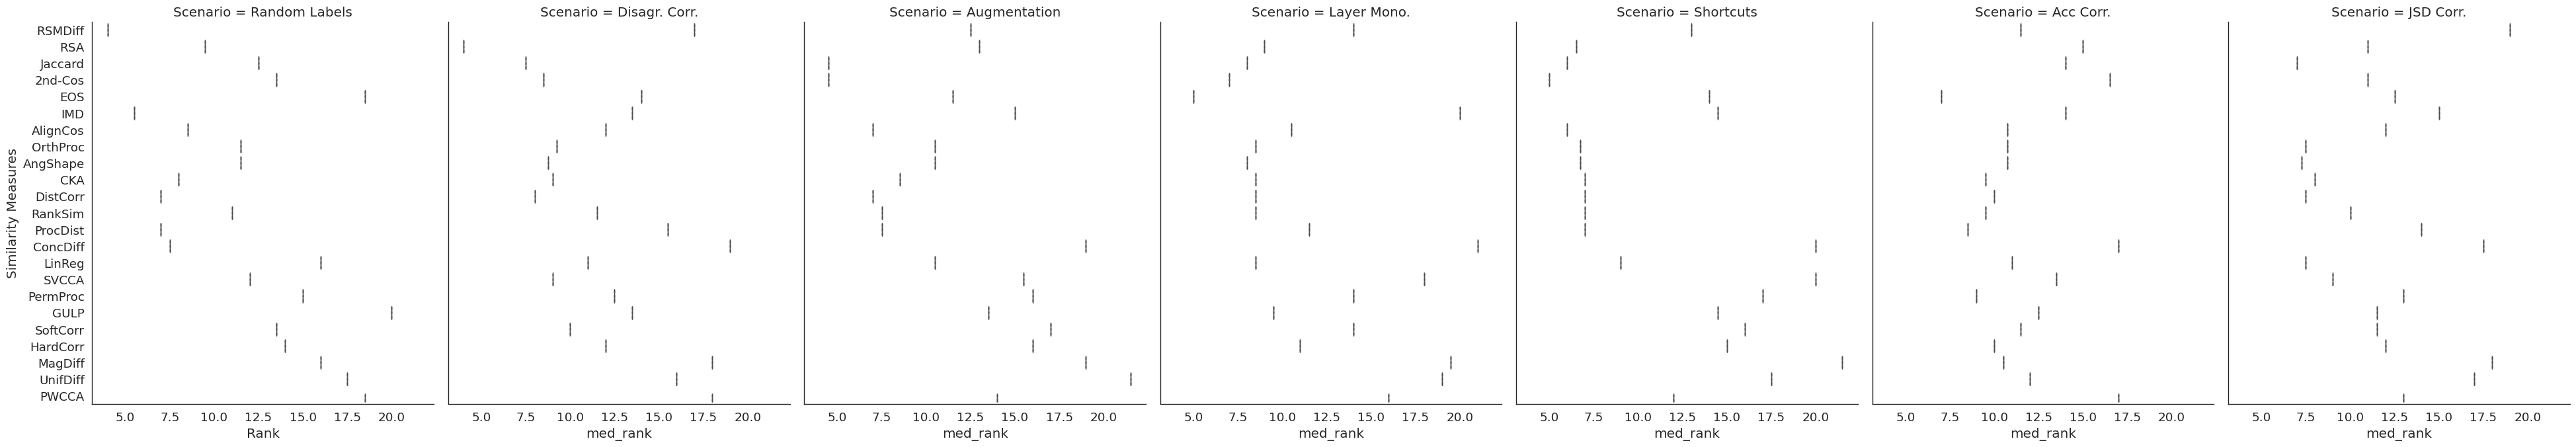

In [33]:
plot_data = pd.merge(data, avg_ranks).sort_values(by=["med_rank"])
g = sns.catplot(
    data=plot_data,
    x="med_rank",
    y="Sim Meas.",
    hue="Modality",
    kind="box",
    height=7,
    aspect=0.8,
    col="Scenario",
    palette={"Language": "C1", "Vision": "C2", "Graph": "C0"},
    legend=False
)
ax = g.axes[0, 0]
ax.set_xlabel("Rank")
ax.set_ylabel("Similarity Measures")